# Exploratory Data Analysis on NFT transfer data for Popularity Ranking

## 1. Goal

### By the end of this notebook, we will:
- Understahd what EDA is for and which tools we use.
- Understand how to screen and use NFT transfer data to do popularity ranking.
- Be able to understand the univariate distiribution of value (price), token_address, and token_id.

## 2. Todos
- Multivariate visualizations, for mapping and understanding interactions between different fields in the data.
- K-means Clustering.
- Predictive models, such as linear regression, use statistics and data to predict outcomes.
- Use API to find blacklist candidates. 


## 3. Imports
- collections.abc Iterator for typing
- datetime date, timedelta to iterate over the range of dates
- [web3](https://web3py.readthedocs.io/en/stable/) Web3 to convert from wei to ether
- logging to log info, warnings, and errors
- [matplotlib](https://matplotlib.org/).pyplot to plot data
- os to validate local paths and generate paths
- [pandas](https://pandas.pydata.org/) to handle data
- string for typing
- warnings for suppressing warnings in the notebook

In [1]:
%matplotlib inline
# Import libraries
from collections.abc import Iterator
from datetime import date, timedelta
from web3 import Web3

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import string
import warnings
warnings.filterwarnings('ignore')

## 4. Helper Functions
- `iterate_dates`: Yields date in range of [start_date, end_date].
- `convert_value_from_wei`: Converts value in WEI to unit for transfers where possible units are 'kwei', 'mwei', 'gwei', 'microether', 'milliether', 'ether'.
- `load_transfer_data`: Loads NFT token transfer data with value in ether from start_date to end_date.
- `get_outliers`: Returns the numpy array of outlier values from a column.
- `get_high_outliers`: Returns the array of high outliers from a column.
- `get_inliers`: Returns the array of inliers from a column.

In [2]:
def iterate_dates(start_date: date, end_date: date) -> Iterator[date]:
    '''Yields date in range of [start_date, end_date]

    Args:
        start_date: inclusive start date
        end_date: inclusive end date
    '''
    for n in range(int((end_date - start_date).days)+1):
        yield start_date + timedelta(n)

def convert_value_from_wei(transfers: pd.DataFrame, unit: string) -> pd.DataFrame:
    '''Convert value in WEI to unit for transfers
        where possible units are 'kwei', 'mwei', 'gwei', 'microether', 'milliether', 'ether'

    Args:
        transfers: dataframe you want to convert the value of
        unit: unit to convert to

    Returns:
        a new dataframe with converted value

    Raises:
        ValueError if unit is not valid
    '''
    if unit not in ['kwei', 'mwei', 'gwei', 'microether', 'milliether', 'ether']:
        raise ValueError("Invalid unit")
    values_in_ether = transfers['value'].apply(lambda x: float(Web3.fromWei(int(x), unit)))
    transfers['value'] = values_in_ether
    return transfers

def load_transfer_data(start_date: date, end_date: date, local_path: string) -> pd.DataFrame:
    """Loads NFT token transfer data with value in ether from start_date to end_date

    Args:
        start_date: an inclusive start date for nft token transfers
        end_date: an inclusive end date for nft token transfers
        local_path: a local path where the nft toke transfer date is located
    
    Returns:
        concatenated transfers dataframe for [start_date, end_date]

    Raises:
        ValueError: if start_date is greater than end_date
        FileNotFoundError: if local_path does not exist or if no csv file is found in the local_path
    """
    if not os.path.exists(local_path):
        raise FileNotFoundError("The local_path does not exist")
    if start_date > end_date:
        raise ValueError("The 'end_date' should be equal to or greather than 'start_date'")

    transfers_list = []
    for date_ in iterate_dates(start_date, end_date):
        fname = os.path.join(local_path, "nft_token_transfers={}.csv".format(date_.strftime("%Y-%m-%d")))
        if os.path.exists(fname):
            transfers = pd.read_csv(fname, low_memory=False)
            transfers = convert_value_from_wei(transfers, 'ether')
            transfers_list.append(transfers)
        else:
            logging.error(f"{fname} does not exist")
    
    if transfers_list:
        return pd.concat(transfers_list, ignore_index=True)
    else:
        raise FileNotFoundError(f"No csv file was loaded from {local_path}")
        
def get_outliers(column: pd.Series) -> np.array:
    """Returns the array of outliers from a column
    
    Args:
        column: a pandas series of values
        
    Returns:
        numpy array of outliers
    """
    outliers=[]
    Q1 = column.quantile(.25)
    Q3 = column.quantile(.75)
    IQR = Q3 - Q1
    lo = Q1 - (1.5 * IQR)
    hi = Q3 + (1.5 * IQR)
    for e in column:
        if e > hi or e < lo:
            outliers.append(e)
    
    return np.array(outliers)

def get_high_outliers(column: pd.Series) -> np.array:
    """Returns the array of high outliers from a column
    
    Args:
        column: a pandas series of values
        
    Returns:
        numpy array of high outliers
    """
    outliers=[]
    Q1 = column.quantile(.25)
    Q3 = column.quantile(.75)
    IQR = Q3 - Q1
    hi = Q3 + (1.5 * IQR)
    for e in column:
        if e > hi:
            outliers.append(e)
    
    return np.array(outliers)

def get_inliers(column: pd.Series) -> np.array:
    """Returns the array of inliers from a column
    
    Args:
        column: a pandas series of values
        
    Returns: 
        numpy array of inliers
    """
    inliers=[]
    Q1 = column.quantile(.25)
    Q3 = column.quantile(.75)
    IQR = Q3 - Q1    
    lo = Q1 - (1.5 * IQR)
    hi = Q3 + (1.5 * IQR)
    for e in column:
        if e <= hi and e >= lo:
            inliers.append(e)
    
    return np.array(inliers)

## 5. Loading NFT Transfer Data Set
- Loading nft_token_transfers={`date`}.csv where date = 2022/05/01 ~ 2022/08/03
### File Information
   - nft_token_transfers={`date`}.csv: This .csv file contains data about NFT transfers on `date`.

In [3]:
%%time
# Load transfer data for multiple dates in range [start_date, end_date]
start_date = date(2022,5,1)
end_date = date(2022,8,3)
local_path = "../../../nft-recommendation-data-analysis-data/nft-token-transfers"
transfers = load_transfer_data(start_date, end_date, local_path)

ERROR:root:../../../nft-recommendation-data-analysis-data/nft-token-transfers/nft_token_transfers=2022-05-19.csv does not exist
ERROR:root:../../../nft-recommendation-data-analysis-data/nft-token-transfers/nft_token_transfers=2022-05-20.csv does not exist
ERROR:root:../../../nft-recommendation-data-analysis-data/nft-token-transfers/nft_token_transfers=2022-05-21.csv does not exist
ERROR:root:../../../nft-recommendation-data-analysis-data/nft-token-transfers/nft_token_transfers=2022-05-22.csv does not exist
ERROR:root:../../../nft-recommendation-data-analysis-data/nft-token-transfers/nft_token_transfers=2022-05-23.csv does not exist
ERROR:root:../../../nft-recommendation-data-analysis-data/nft-token-transfers/nft_token_transfers=2022-05-24.csv does not exist
ERROR:root:../../../nft-recommendation-data-analysis-data/nft-token-transfers/nft_token_transfers=2022-05-25.csv does not exist
ERROR:root:../../../nft-recommendation-data-analysis-data/nft-token-transfers/nft_token_transfers=2022-0

CPU times: user 1min 57s, sys: 10.5 s, total: 2min 8s
Wall time: 2min 8s


## 6. Exploratory Data Analysis (EDA)

We analyze and investigate the NFT transfer data set and summarize its main characteristic with data visualization methods. We will gain insignts into how best to manipulate the data to get the best ranking. We will discover patterns, spot anomalies, and check assumptions. In short, EDA provides a better understanding of data set variables and the relationships between them.

We will be using:
- Univariate visualization of each field in the raw dataset, with summary statistics.

We will:
- Screen data.
- Identify outliers.
- Check assumptions.


### 6.1 Basic Analysis

- Total # of transactions.
- Features: 
    - amount
    - block_hash
    - block_number
    - block_timestamp
    - contract_type
    - from_address
    - log_index, operator
    - to_address
    - token_address
    - token_id
    - transaction_hash
    - transaction_index
    - transaction_type
    - value 
    - verified
- Data types of each columns.
    - Confirm that value is saved in floats.
    - In the future, it will be better to import block_timestamp as datetime or is it already?
- Checks the uniqueness of each column.
    - Why do we have multiple contract_types and amount?

In [4]:
transfers.head()

,amount,block_hash,block_number,block_timestamp,contract_type,from_address,log_index,operator,to_address,token_address,token_id,transaction_hash,transaction_index,transaction_type,value,verified
0,1,0xb58d4afaac7009f3bceb77c615aaae3af3853d8586d2...,14695010,2022-05-01T23:59:13.000Z,ERC1155,0x27792e7d87a5f05334b52c0584ad8497852aef8b,675,0xae9d5478814305148fe82dbea70e72c7ff0abbde,0x6d18e2fd549e5a816fbce4aee665283db243caf9,0x495f947276749ce646f68ac8c248420045cb7b5e,1785431045419628203587059284159807424926884684...,0xfa59235a4aba3f57b295090cd6f9bce2f7f7006c1136...,317,Single,0.000000,1
1,1,0xb58d4afaac7009f3bceb77c615aaae3af3853d8586d2...,14695010,2022-05-01T23:59:13.000Z,ERC721,0x59346047b015a159e5340122b0c9134043dc00e1,668,NaN,0x9d08b5dea1cbd21e8eb76e49d69746909ba2239d,0x34d85c9cdeb23fa97cb08333b511ac86e1c4e258,51199,0xf75ff58cd2186a85fb3f957340b2564733da530f16a8...,312,Single,0.000000,1
2,1,0xb58d4afaac7009f3bceb77c615aaae3af3853d8586d2...,14695010,2022-05-01T23:59:13.000Z,ERC721,0x283af0b28c62c092c9727f1ee09c02ca627eb7f5,664,NaN,0xf7a766f28e561fc25fe5c445fdcd8e353afc3d63,0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85,3371214892998853998010100240008899446379973043...,0xda3143b89a0c701afe5a17346625d1129c9d2ba3cfc6...,308,Single,0.001945,1
3,1,0xb58d4afaac7009f3bceb77c615aaae3af3853d8586d2...,14695010,2022-05-01T23:59:13.000Z,ERC721,0x0000000000000000000000000000000000000000,657,NaN,0x283af0b28c62c092c9727f1ee09c02ca627eb7f5,0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85,3371214892998853998010100240008899446379973043...,0xda3143b89a0c701afe5a17346625d1129c9d2ba3cfc6...,308,Single,0.001945,1
4,1,0xb58d4afaac7009f3bceb77c615aaae3af3853d8586d2...,14695010,2022-05-01T23:59:13.000Z,ERC721,0xb56753544255746c4e9647df7d2e641f8b13c6ba,636,NaN,0xbb14199294a45467b760db495c0a767bfc057f8a,0xd9b78a2f1dafc8bb9c60961790d2beefebee56f4,2792,0x9437e96a57f91ceb71e7d971b894f6b1443894fb067a...,302,Single,0.310000,1


In [5]:
# Print out all column names
print(f'The shape of data: {transfers.shape}')
for i, col_name in enumerate(transfers.columns):
    print(f"Column {i}: {col_name}")

The shape of data: (38599376, 16)
Column 0: amount
Column 1: block_hash
Column 2: block_number
Column 3: block_timestamp
Column 4: contract_type
Column 5: from_address
Column 6: log_index
Column 7: operator
Column 8: to_address
Column 9: token_address
Column 10: token_id
Column 11: transaction_hash
Column 12: transaction_index
Column 13: transaction_type
Column 14: value
Column 15: verified


In [6]:
# Checks for uniqueness
transfers.nunique(axis=0)

amount                  15978
block_hash             505299
block_number           505299
block_timestamp        505299
contract_type               3
from_address           994132
log_index               14067
operator               331575
to_address            1975828
token_address           61625
token_id              1703049
transaction_hash     15955857
transaction_index        1124
transaction_type            2
value                  210498
verified                    2
dtype: int64

In [7]:
# Prints out data types of the columns
transfers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38599376 entries, 0 to 38599375
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   amount             object 
 1   block_hash         object 
 2   block_number       int64  
 3   block_timestamp    object 
 4   contract_type      object 
 5   from_address       object 
 6   log_index          int64  
 7   operator           object 
 8   to_address         object 
 9   token_address      object 
 10  token_id           object 
 11  transaction_hash   object 
 12  transaction_index  int64  
 13  transaction_type   object 
 14  value              float64
 15  verified           int64  
dtypes: float64(1), int64(4), object(11)
memory usage: 4.6+ GB


### 6.2 Initial Data Screening
- Handle Nulls.
- Filter out non ERC721's.
- Manually checked and CryptoPunks did not have contract type.
- Keeping only ERC721 is not advised.

#### 6.2.1 Handle Nulls
- Counts the number of nulls in each column.
- There are some Null in contract_type, operator, and token_id.
- All Null items are replace by "N/A".

In [8]:
transfers.isnull().sum()

amount                      0
block_hash                  0
block_number                0
block_timestamp             0
contract_type            2871
from_address                0
log_index                   0
operator             35408159
to_address                  0
token_address               0
token_id                 2967
transaction_hash            0
transaction_index           0
transaction_type            0
value                       0
verified                    0
dtype: int64

In [9]:
transfers.fillna("N/A", inplace=True)

In [10]:
transfers.isnull().sum()

amount               0
block_hash           0
block_number         0
block_timestamp      0
contract_type        0
from_address         0
log_index            0
operator             0
to_address           0
token_address        0
token_id             0
transaction_hash     0
transaction_index    0
transaction_type     0
value                0
verified             0
dtype: int64

#### 6.2.2 Contract Type
- Check that ERC721 is most of the data.
- Keep ERC721 and N/A contract types.
- Confirm that all ERC721 has amount == 1 (sanity check).

In [11]:
contract_type = transfers['contract_type']

In [12]:
contract_type.value_counts()

ERC721     35374781
ERC1155     3213502
ERC165         8222
N/A            2871
Name: contract_type, dtype: int64

In [13]:
contract_type.value_counts(normalize=True)

ERC721     0.916460
ERC1155    0.083253
ERC165     0.000213
N/A        0.000074
Name: contract_type, dtype: float64

In [14]:
transfers = transfers[(transfers['contract_type'] == "ERC721") | (transfers['contract_type'] == "N/A")]

In [15]:
transfers['amount'].value_counts(normalize=True)

1    1.0
Name: amount, dtype: float64

### 6.3 Redo Basic Analysis

In [16]:
transfers.shape

(35377652, 16)

In [17]:
transfers.head()

,amount,block_hash,block_number,block_timestamp,contract_type,from_address,log_index,operator,to_address,token_address,token_id,transaction_hash,transaction_index,transaction_type,value,verified
1,1,0xb58d4afaac7009f3bceb77c615aaae3af3853d8586d2...,14695010,2022-05-01T23:59:13.000Z,ERC721,0x59346047b015a159e5340122b0c9134043dc00e1,668,N/A,0x9d08b5dea1cbd21e8eb76e49d69746909ba2239d,0x34d85c9cdeb23fa97cb08333b511ac86e1c4e258,51199,0xf75ff58cd2186a85fb3f957340b2564733da530f16a8...,312,Single,0.000000,1
2,1,0xb58d4afaac7009f3bceb77c615aaae3af3853d8586d2...,14695010,2022-05-01T23:59:13.000Z,ERC721,0x283af0b28c62c092c9727f1ee09c02ca627eb7f5,664,N/A,0xf7a766f28e561fc25fe5c445fdcd8e353afc3d63,0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85,3371214892998853998010100240008899446379973043...,0xda3143b89a0c701afe5a17346625d1129c9d2ba3cfc6...,308,Single,0.001945,1
3,1,0xb58d4afaac7009f3bceb77c615aaae3af3853d8586d2...,14695010,2022-05-01T23:59:13.000Z,ERC721,0x0000000000000000000000000000000000000000,657,N/A,0x283af0b28c62c092c9727f1ee09c02ca627eb7f5,0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85,3371214892998853998010100240008899446379973043...,0xda3143b89a0c701afe5a17346625d1129c9d2ba3cfc6...,308,Single,0.001945,1
4,1,0xb58d4afaac7009f3bceb77c615aaae3af3853d8586d2...,14695010,2022-05-01T23:59:13.000Z,ERC721,0xb56753544255746c4e9647df7d2e641f8b13c6ba,636,N/A,0xbb14199294a45467b760db495c0a767bfc057f8a,0xd9b78a2f1dafc8bb9c60961790d2beefebee56f4,2792,0x9437e96a57f91ceb71e7d971b894f6b1443894fb067a...,302,Single,0.310000,1
5,1,0xb58d4afaac7009f3bceb77c615aaae3af3853d8586d2...,14695010,2022-05-01T23:59:13.000Z,ERC721,0xfc1207ab36d0aafebf9d27473326ead93e3b0cb8,633,N/A,0x636e5f84c3abab43802595cefe6ac3c0687da411,0xafe12842e3703a3cc3a71d9463389b1bf2c5bc1c,358,0x99224683b1fabf3de871251b564b9819775072f7c8d5...,301,Single,0.018000,1


In [18]:
transfers.nunique(axis=0)

amount                      1
block_hash             503690
block_number           503690
block_timestamp        503690
contract_type               2
from_address           898103
log_index               14067
operator                    3
to_address            1768351
token_address           54380
token_id              1445491
transaction_hash     14651050
transaction_index        1117
transaction_type            1
value                  204265
verified                    2
dtype: int64

### 6.4 Univariate Analysis with Focus On Value (Price)

#### 6.4.1 Value (Price in ether)
- We have many questions about if price data is solid.
- Terraforms parsing seems to be wierd specifically.
- Overall price data is very noisy, even at the top outlier section.
- There is sudden rise in frequency at high price just for a single region.
- Most transactions are 0 valued or valued very close to 0.

##### 6.4.1.1 Basic Analysis
- The data is heavily right-skewed with the skewedness score ([SS](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.skew.html)), where positive SS means right-skewed and negative SS means left-skewed
- We confirm our statistical observation with box plot.

In [19]:
value = transfers['value']
value

1           0.000000
2           0.001945
3           0.001945
4           0.310000
5           0.018000
              ...   
38599371    0.000000
38599372    0.000000
38599373    0.000000
38599374    0.000000
38599375    0.000000
Name: value, Length: 35377652, dtype: float64

In [20]:
value.describe()

count    3.537765e+07
mean     2.692828e-01
std      2.015947e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e-02
max      2.695200e+04
Name: value, dtype: float64

In [21]:
value.skew()

753.1684518946765

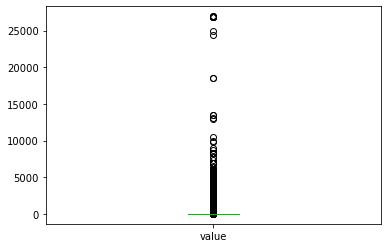

In [22]:
value.plot.box()
plt.show()

##### 6.4.1.2 Filter out 0 value transaction - There are 67.10% of 0 value transactions.
- There are 67.10% of 0 value transactions.
    - They seem to be transfers and no sales.
- After filtering out 0 value, the SS improved to 432.739, but still very bad.
- Keeps non 0 transfers for further analysis.

In [23]:
value_0 = transfers[transfers['value'] == 0]
num_value_0 = value_0.shape[0]
print(23737752 / 35374781)

0.6710360129155287


In [24]:
filtered_value = value[value != 0]
filtered_value

2             0.001945
3             0.001945
4             0.310000
5             0.018000
8           175.000000
               ...    
38599305      0.090000
38599310      0.008900
38599311      0.008900
38599359      0.008900
38599360      0.008900
Name: value, Length: 11638069, dtype: float64

In [25]:
filtered_value.describe()

count    1.163807e+07
mean     8.185715e-01
std      3.514181e+01
min      1.000000e-18
25%      1.050000e-02
50%      4.980000e-02
75%      1.690000e-01
max      2.695200e+04
Name: value, dtype: float64

In [26]:
filtered_value.skew()

432.1735036451095

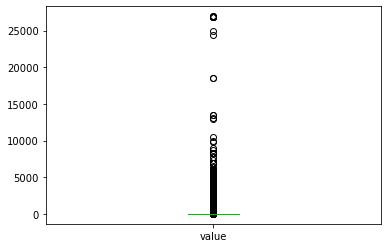

In [27]:
filtered_value.plot.box()
plt.show()

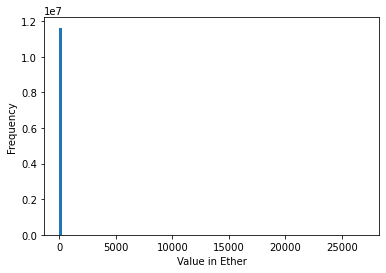

In [28]:
filtered_value.plot.hist(bins=100)
plt.xlabel("Value in Ether")
plt.show()

In [29]:
transfers = transfers[transfers.value > 0]

##### 6.4.1.3 Try Transforms
- Tried taking [log-transformation](https://en.wikipedia.org/wiki/Logarithm), but due to many close to 0 values, we get left-skewed data.
    - We should consider doing computation in different [unit](https://www.gemini.com/cryptopedia/satoshi-value-gwei-to-ether-to-wei-converter-eth-gwei) to deal less with decimal numbers.
    - Can we try with different log base?
- Taking [square-root transformation](https://en.wikipedia.org/wiki/Square_root) (squeezing effect) or (maz-min) normalization did not help much due to extreme outliers.

In [30]:
log_transformed_value = filtered_value.apply(np.log)

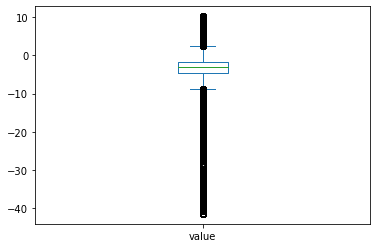

In [31]:
log_transformed_value.plot.box()
plt.show()

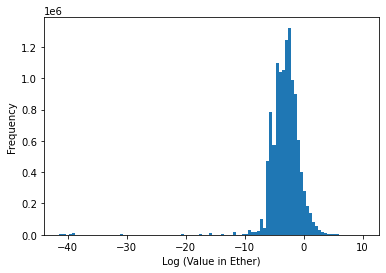

In [32]:
log_transformed_value.plot.hist(bins=100)
plt.xlabel("Log (Value in Ether)")
plt.show()

In [33]:
log_transformed_value.skew()

-5.76521658367982

In [34]:
sqrt_transformed_value = filtered_value.apply(np.sqrt)

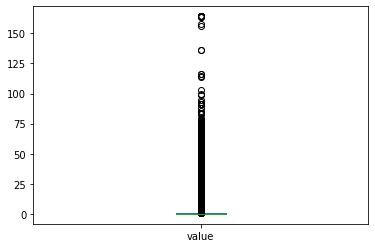

In [35]:
sqrt_transformed_value.plot.box()
plt.show()

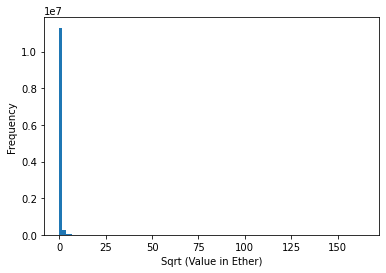

In [36]:
sqrt_transformed_value.plot.hist(bins=100)
plt.xlabel("Sqrt (Value in Ether)")
plt.show()

In [37]:
sqrt_transformed_value.skew()

29.91767568887387

In [38]:
normalized_value = (filtered_value / filtered_value.mean()) / filtered_value.std()

In [39]:
normalized_value.skew()

432.173503645107

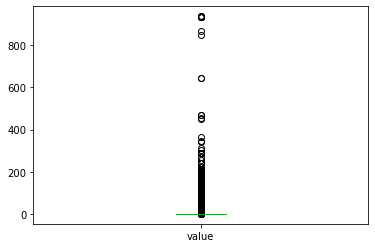

In [40]:
normalized_value.plot.box()
plt.show()

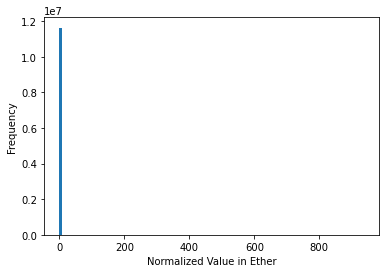

In [41]:
normalized_value.plot.hist(bins=100)
plt.xlabel("Normalized Value in Ether")
plt.show()

##### 6.4.1.4 Identify Outliers
- Out of all the outliers 100% of them are high outliers, that are above Q1 (pretty obvious from the previous histogram).
- The high outliers themselves are heavily right-skewed as well.

In [42]:
outliers = get_outliers(filtered_value)

In [43]:
high_outliers = get_high_outliers(filtered_value)

In [44]:
len(high_outliers) / len(outliers)

1.0

In [45]:
np.min(high_outliers)

0.40678622142293935

In [46]:
high_outliers = pd.Series(high_outliers)

In [47]:
high_outliers.describe()

count    1.507793e+06
mean     5.833637e+00
std      9.748402e+01
min      4.067862e-01
25%      6.000000e-01
50%      9.900000e-01
75%      2.302830e+00
max      2.695200e+04
dtype: float64

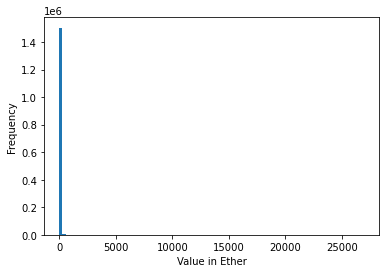

In [48]:
high_outliers.plot.hist(bins=100)
plt.xlabel("Value in Ether")
plt.show()

In [49]:
high_outliers.skew()

156.11362337056764

##### 6.4.1.5 Try Ranking with Top Value Transcations
- Not so good.
- Blacklist:
    - 0xe786b5596a792d7beafcf08eaf9de711c7b7b14b (not available any more) to blacklist.

In [50]:
high_outliers.sort_values(ascending=False).head(10)

778617     26952.000000
786566     26952.000000
757866     26914.000000
758405     26914.000000
756420     26913.999845
738498     26877.000000
712455     26872.000000
294639     25000.000000
1284670    24329.000000
717254     18476.000000
dtype: float64

In [51]:
for rank, i in enumerate(high_outliers.sort_values(ascending=False).head(10).index.values):
    print(f"https://opensea.io/assets/ethereum/{transfers.iloc[i].token_address}/{transfers.iloc[i].token_id}")

https://opensea.io/assets/ethereum/0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85/90330141559067330348100661400037728936860528297692356196704825531921747852049
https://opensea.io/assets/ethereum/0x13d66dbace34218fddaf50f7057092a43507adef/5585
https://opensea.io/assets/ethereum/0x3b8420eb6ef77bc25025b32d8205cde2683f979e/2850
https://opensea.io/assets/ethereum/0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85/3775412211110698559507407168889921979788193658315639870822486099160278105418
https://opensea.io/assets/ethereum/0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85/53940848497051110815272310637608580885927594680206949856538624585433695987367
https://opensea.io/assets/ethereum/0x7d8820fa92eb1584636f4f5b8515b5476b75171a/5851
https://opensea.io/assets/ethereum/0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85/71075691972228546839934580618238740032275021032661525626165018601135867074334
https://opensea.io/assets/ethereum/0x49bd963f01588adf5c118d3eab2e5ae0dcf5ec0c/339
https://opensea.io/assets/ethereum/0x17f05df82

#### 6.4.2 Token Address
- Token address is used to distinguish different contracts.

##### 6.4.2.1 Basic Analysis

- There is a great inbalance in transaction counts for different NFTs.
- It is heavily right-skewed, but not as much as price.

In [52]:
token_address = transfers['token_address']
token_address.describe()

count                                       11638069
unique                                         23137
top       0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85
freq                                         1670504
Name: token_address, dtype: object

##### 6.4.2.2 Collection Transaction Count

In [53]:
token_address_count = transfers['token_address'].value_counts()
token_address_count.describe()

count    2.313700e+04
mean     5.030068e+02
std      1.112730e+04
min      1.000000e+00
25%      2.000000e+00
50%      1.400000e+01
75%      1.390000e+02
max      1.670504e+06
Name: token_address, dtype: float64

In [54]:
transfers['token_address'].value_counts(normalize=True).sort_values(ascending=False)

0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85    1.435379e-01
0x34d85c9cdeb23fa97cb08333b511ac86e1c4e258    4.685915e-03
0xc36442b4a4522e871399cd717abdd847ab11fe88    3.368772e-03
0x76b3af5f0f9b89ca5a4f9fe6c58421dbe567062d    3.223215e-03
0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270    3.052482e-03
                                                  ...     
0x0446d21d390695cb05d73fb676a9247761f2d9f6    8.592491e-08
0x6b2cf2c3c7db49946d604652dc097f70e067395b    8.592491e-08
0x5ec160241ab6bd4cd619f38adab89341eefe49b5    8.592491e-08
0x4e2e28ed2a76db46ad3703e161f0cf6ecabb1bf9    8.592491e-08
0xe30a7869d929101954fa1747311453b197e66e8a    8.592491e-08
Name: token_address, Length: 23137, dtype: float64

In [55]:
token_address_count.skew()

146.16842609713984

In [56]:
len(get_outliers(token_address_count))

3794

##### 6.4.2.3 Transaction Count per Collection
- Althogh it is not as skewed as price data, ranking based on transaction count does not seem viable.
- Top ranked NFTs according to transaction count is not very good.
- This is kind of expected because good art does not get traded very often. 
- But, the goal of EDA is to have 0 assumptions.
- Blacklist:
    - 0xcbbadd74b3bb09836d97d91050e13e06089ba485
    - 0x72b12aec69da93357f2b69acf33d5b75cf17575b
    - 0xcab80a2bf07becaf8d48168081352ea873b8db91
    - 0x696f33f4dd9be5538483f63308453d2d67d07331
    - 0x56826a77f7a5dacf6476d4239f98bd72f15db703

In [57]:
top_20_transaction_count = token_address_count.sort_values(ascending=False).head(20)

In [58]:
for rank, (address, count) in enumerate(top_20_transaction_count.iteritems()):
    print(f"Rank {rank} with Count {count}: https://etherscan.io/address/{address}")

Rank 0 with Count 1670504: https://etherscan.io/address/0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85
Rank 1 with Count 54535: https://etherscan.io/address/0x34d85c9cdeb23fa97cb08333b511ac86e1c4e258
Rank 2 with Count 39206: https://etherscan.io/address/0xc36442b4a4522e871399cd717abdd847ab11fe88
Rank 3 with Count 37512: https://etherscan.io/address/0x76b3af5f0f9b89ca5a4f9fe6c58421dbe567062d
Rank 4 with Count 35525: https://etherscan.io/address/0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270
Rank 5 with Count 33387: https://etherscan.io/address/0x1485297e942ce64e0870ece60179dfda34b4c625
Rank 6 with Count 33372: https://etherscan.io/address/0x845a007d9f283614f403a24e3eb3455f720559ca
Rank 7 with Count 32654: https://etherscan.io/address/0x5eaeadda470245343249452e744e423f489abbc4
Rank 8 with Count 30606: https://etherscan.io/address/0x05e7f2499ff153fea2f20bbde0b5584c911c0af1
Rank 9 with Count 30527: https://etherscan.io/address/0x011c77fa577c500deedad364b8af9e8540b808c0
Rank 10 with Count 30519: ht

Rank 1 collection by Transaction Count
SS: 105.82849614701391
https://etherscan.io/address/0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85/


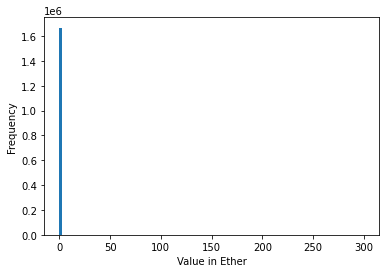

Rank 2 collection by Transaction Count
SS: 6.570267147349441
https://etherscan.io/address/0x34d85c9cdeb23fa97cb08333b511ac86e1c4e258/


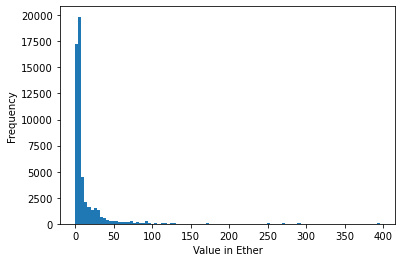

Rank 3 collection by Transaction Count
SS: 28.55262370639752
https://etherscan.io/address/0xc36442b4a4522e871399cd717abdd847ab11fe88/


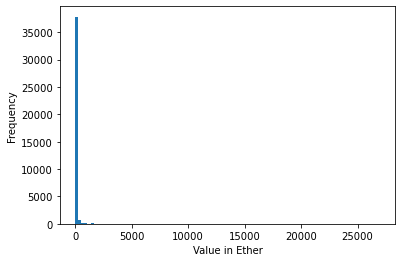

Rank 4 collection by Transaction Count
SS: 9.553921217553142
https://etherscan.io/address/0x76b3af5f0f9b89ca5a4f9fe6c58421dbe567062d/


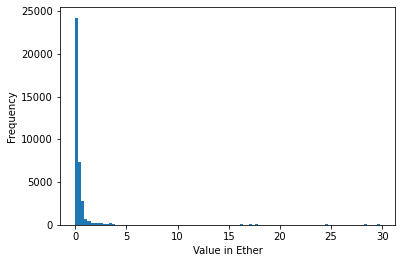

Rank 5 collection by Transaction Count
SS: 12.135329622611852
https://etherscan.io/address/0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270/


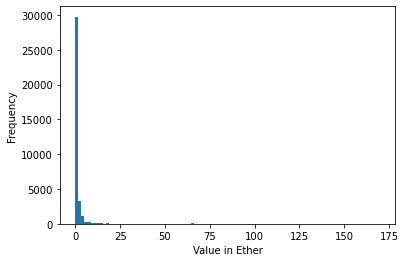

Rank 6 collection by Transaction Count
SS: 5.315197534459559
https://etherscan.io/address/0x1485297e942ce64e0870ece60179dfda34b4c625/


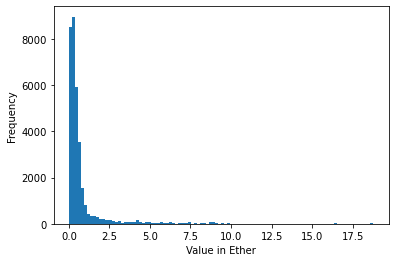

Rank 7 collection by Transaction Count
SS: 17.0935056026301
https://etherscan.io/address/0x845a007d9f283614f403a24e3eb3455f720559ca/


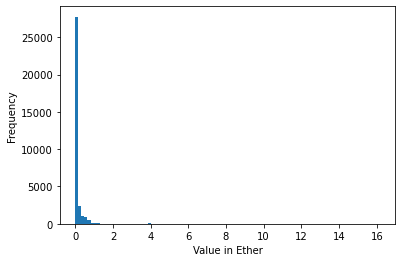

Rank 8 collection by Transaction Count
SS: 3.788767676387239
https://etherscan.io/address/0x5eaeadda470245343249452e744e423f489abbc4/


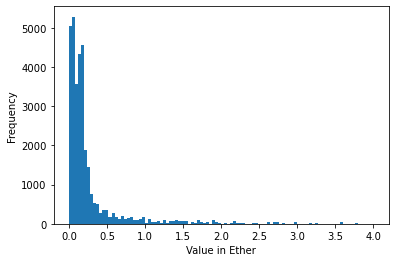

Rank 9 collection by Transaction Count
SS: 6.567789901405678
https://etherscan.io/address/0x05e7f2499ff153fea2f20bbde0b5584c911c0af1/


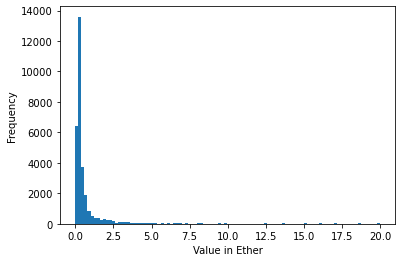

Rank 10 collection by Transaction Count
SS: 8.229155414241788
https://etherscan.io/address/0x011c77fa577c500deedad364b8af9e8540b808c0/


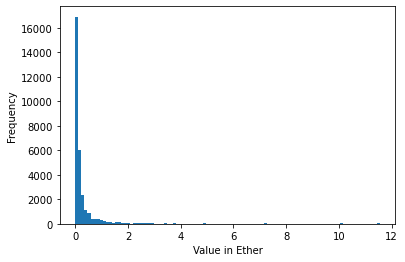

Rank 11 collection by Transaction Count
SS: 5.487615804377261
https://etherscan.io/address/0xc907ddb25a926d51784aedd4cf9c04e3eb5da12c/


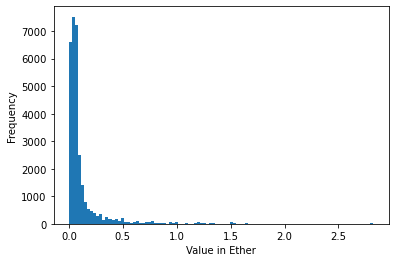

Rank 12 collection by Transaction Count
SS: 8.711506761154324
https://etherscan.io/address/0x9f9b2b8e268d06dc67f0f76627654b80e219e1d6/


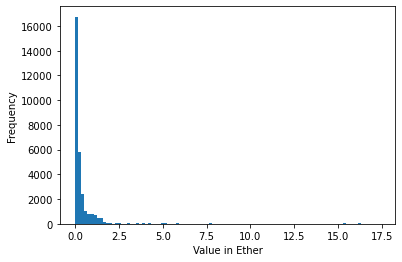

Rank 13 collection by Transaction Count
SS: 7.862608103775015
https://etherscan.io/address/0x160c404b2b49cbc3240055ceaee026df1e8497a0/


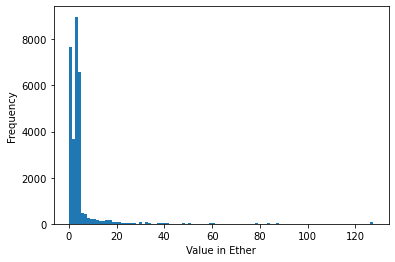

Rank 14 collection by Transaction Count
SS: 18.221291799940953
https://etherscan.io/address/0xd3605059c3ce9facf625fa72d727508b7b7f280f/


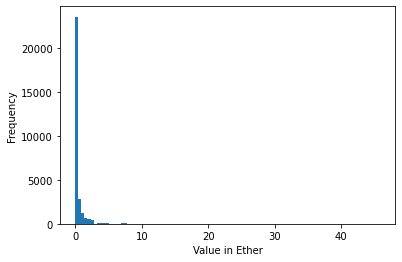

Rank 15 collection by Transaction Count
SS: 7.638064063247135
https://etherscan.io/address/0x415f77738147a65a9d76bb0407af206a921cee0f/


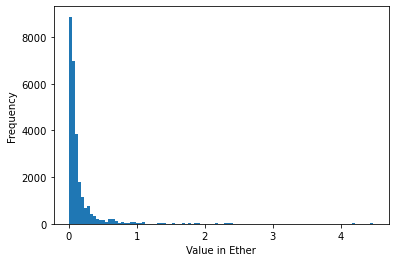

Rank 16 collection by Transaction Count
SS: 2.5395241711585075
https://etherscan.io/address/0xdcaf23e44639daf29f6532da213999d737f15aa4/


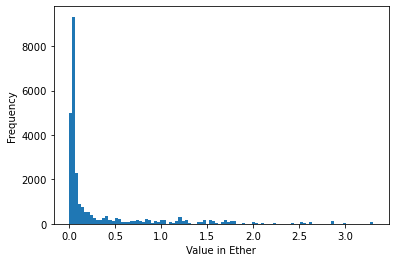

Rank 17 collection by Transaction Count
SS: 8.434166500204027
https://etherscan.io/address/0x4052425a34a35e53d916d94393cbc4eb1c572c3c/


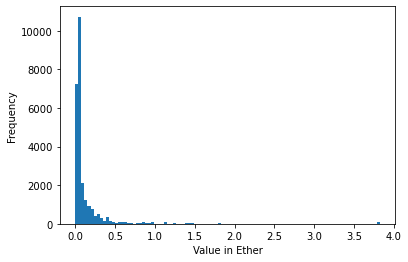

Rank 18 collection by Transaction Count
SS: 5.115109361730646
https://etherscan.io/address/0x1e4afe0c027d4f14fdba4254efc1a3ac2f7d49b5/


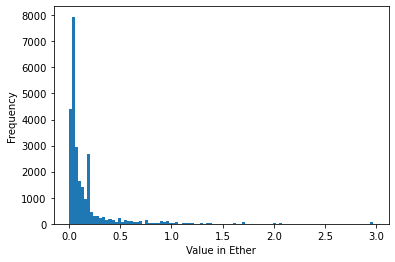

Rank 19 collection by Transaction Count
SS: 5.162625320345633
https://etherscan.io/address/0x0ee80069c9b4993882fe0b3fc256260eff385982/


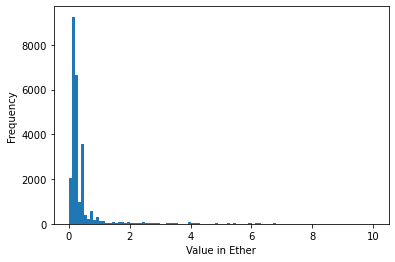

Rank 20 collection by Transaction Count
SS: 4.475812791419141
https://etherscan.io/address/0x3cf57cc9cf5263748c6f926ff498ac0c6f95b26e/


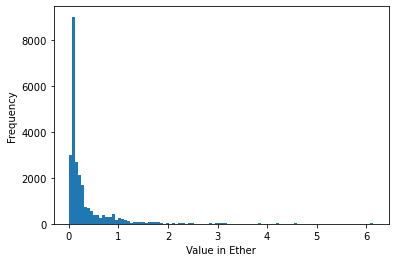

In [59]:
for rank, idx in enumerate(top_20_transaction_count.index.values):
    collection_value = transfers[transfers['token_address'] == idx]['value']
    print(f"Rank {rank+1} collection by Transaction Count")
    print("SS: {}".format(collection_value.skew()))
    print(f"https://etherscan.io/address/{idx}/")
    collection_value.plot.hist(bins=100)
    plt.xlabel("Value in Ether")
    plt.show()

##### 6.4.2.4 Total Transaction Value (Price) per Collection
- The value (price) per collection is heavily skewed also with many outliers
- Due to heavy skewedness it will be not wise to compute average to summarize the characteristics of collections. 
- Total is more advised.
- Blacklist add:
    - 0xc36442b4a4522e871399cd717abdd847ab11fe88 (Uniswap)

In [60]:
total_value_per_collection = transfers.groupby(['token_address'])['value'].sum()

In [61]:
total_value_per_collection.describe()

count    2.313700e+04
mean     4.117471e+02
std      1.780292e+04
min      1.000000e-18
25%      1.080000e-01
50%      8.500000e-01
75%      1.010854e+01
max      2.435802e+06
Name: value, dtype: float64

In [62]:
total_value_per_collection.skew()

116.13712507710746

In [63]:
top_20_total_value_collections = total_value_per_collection.sort_values(ascending=False).head(20)

In [64]:
for rank, (address, count) in enumerate(top_20_total_value_collections.iteritems()):
    print(f"Rank {rank} with Count {count}: https://etherscan.io/address/{address}")

Rank 0 with Count 2435802.4155549803: https://etherscan.io/address/0xc36442b4a4522e871399cd717abdd847ab11fe88
Rank 1 with Count 750437.345667492: https://etherscan.io/address/0x34d85c9cdeb23fa97cb08333b511ac86e1c4e258
Rank 2 with Count 494079.85706077464: https://etherscan.io/address/0x81ae0be3a8044772d04f32398bac1e1b4b215aa8
Rank 3 with Count 465755.9339827968: https://etherscan.io/address/0x1dfe7ca09e99d10835bf73044a23b73fc20623df
Rank 4 with Count 311173.59483725583: https://etherscan.io/address/0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7
Rank 5 with Count 270063.79444542713: https://etherscan.io/address/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d
Rank 6 with Count 177039.74632709823: https://etherscan.io/address/0xad6917fc71101d377f5cbbc5b1fc0e941f08ae58
Rank 7 with Count 164998.4779737034: https://etherscan.io/address/0xed5af388653567af2f388e6224dc7c4b3241c544
Rank 8 with Count 135655.23648640554: https://etherscan.io/address/0x160c404b2b49cbc3240055ceaee026df1e8497a0
Rank 9 with Co

Rank 1 collection by Total Value
SS: 28.55262370639752
https://etherscan.io/address/0xc36442b4a4522e871399cd717abdd847ab11fe88/


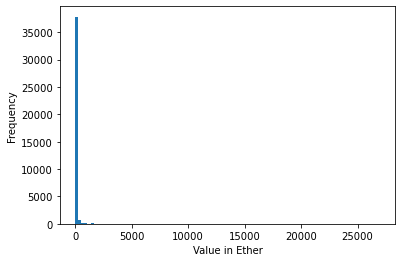

Rank 2 collection by Total Value
SS: 6.570267147349441
https://etherscan.io/address/0x34d85c9cdeb23fa97cb08333b511ac86e1c4e258/


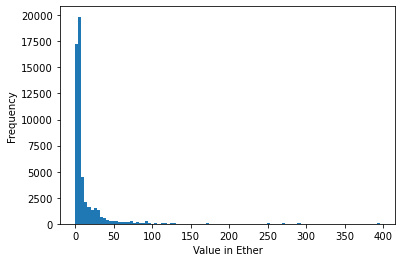

Rank 3 collection by Total Value
SS: -0.18687135855513198
https://etherscan.io/address/0x81ae0be3a8044772d04f32398bac1e1b4b215aa8/


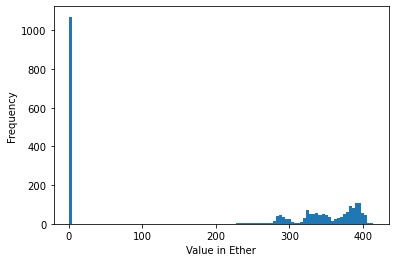

Rank 4 collection by Total Value
SS: 0.6515743341275175
https://etherscan.io/address/0x1dfe7ca09e99d10835bf73044a23b73fc20623df/


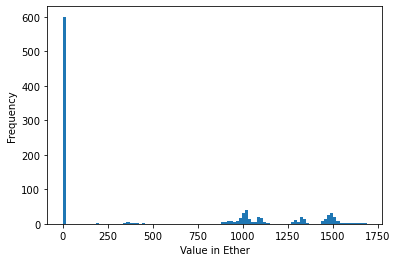

Rank 5 collection by Total Value
SS: 0.38861678654331094
https://etherscan.io/address/0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7/


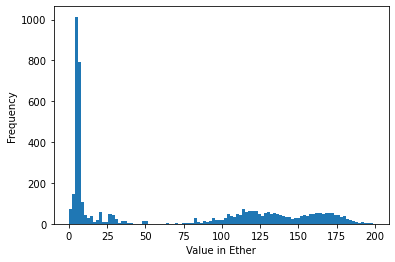

Rank 6 collection by Total Value
SS: 1.870019605572381
https://etherscan.io/address/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d/


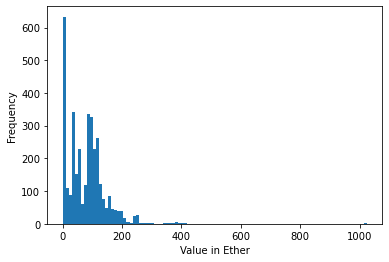

Rank 7 collection by Total Value
SS: 1.1427003659061876
https://etherscan.io/address/0xad6917fc71101d377f5cbbc5b1fc0e941f08ae58/


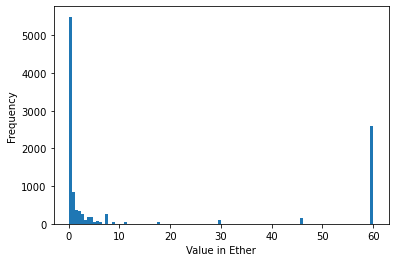

Rank 8 collection by Total Value
SS: 5.1346055523243725
https://etherscan.io/address/0xed5af388653567af2f388e6224dc7c4b3241c544/


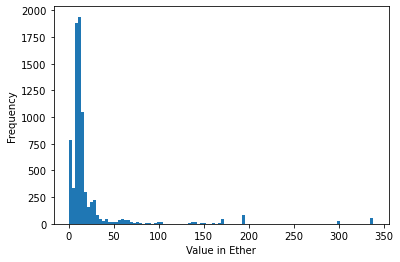

Rank 9 collection by Total Value
SS: 7.862608103775015
https://etherscan.io/address/0x160c404b2b49cbc3240055ceaee026df1e8497a0/


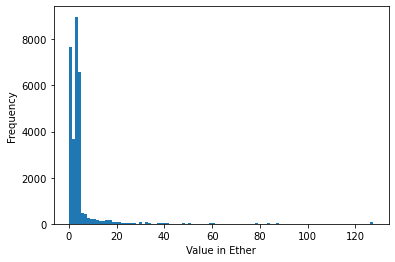

Rank 10 collection by Total Value
SS: 6.772773724540024
https://etherscan.io/address/0x60e4d786628fea6478f785a6d7e704777c86a7c6/


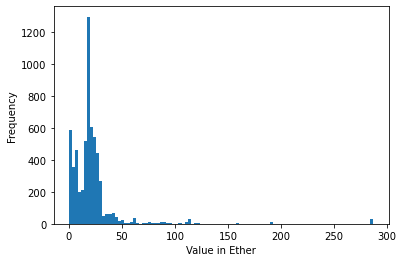

Rank 11 collection by Total Value
SS: 9.68651187458063
https://etherscan.io/address/0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949/


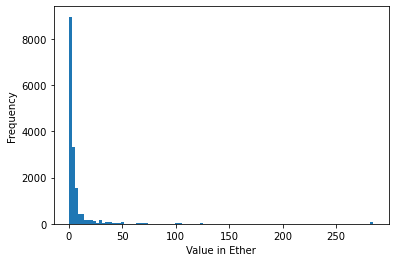

Rank 12 collection by Total Value
SS: 105.82849614701391
https://etherscan.io/address/0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85/


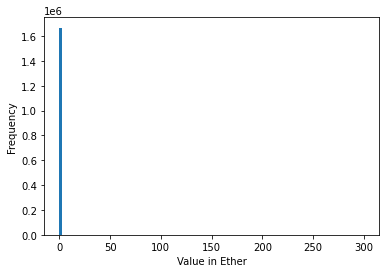

Rank 13 collection by Total Value
SS: 4.09889233984005
https://etherscan.io/address/0x4e1f41613c9084fdb9e34e11fae9412427480e56/


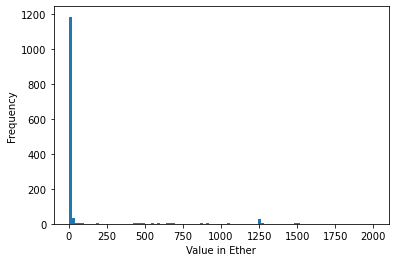

Rank 14 collection by Total Value
SS: -0.09403416282296952
https://etherscan.io/address/0xc73d48167123430958049ca698137927b3c9441c/


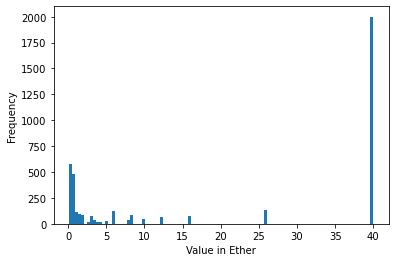

Rank 15 collection by Total Value
SS: 6.143926799269185
https://etherscan.io/address/0x8a90cab2b38dba80c64b7734e58ee1db38b8992e/


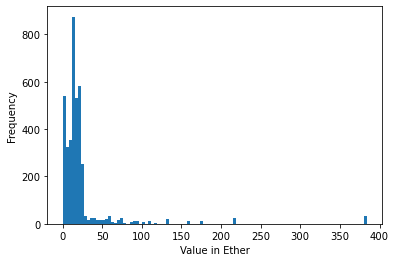

Rank 16 collection by Total Value
SS: 2.3077508990236946
https://etherscan.io/address/0x892848074ddea461a15f337250da3ce55580ca85/


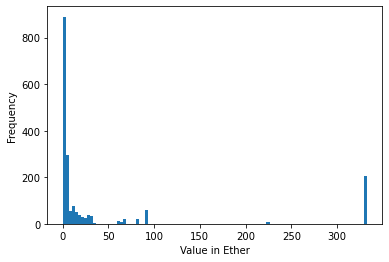

Rank 17 collection by Total Value
SS: 5.8669578416385555
https://etherscan.io/address/0x23581767a106ae21c074b2276d25e5c3e136a68b/


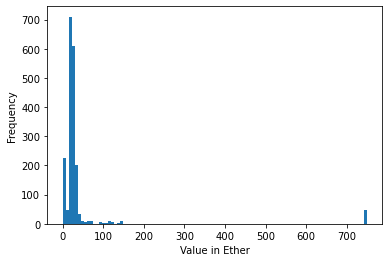

Rank 18 collection by Total Value
SS: 7.041765953210644
https://etherscan.io/address/0xbce3781ae7ca1a5e050bd9c4c77369867ebc307e/


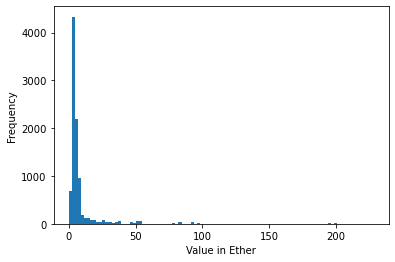

Rank 19 collection by Total Value
SS: 21.51867657137903
https://etherscan.io/address/0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb/


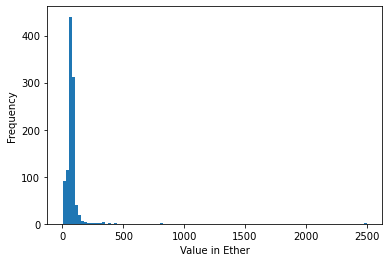

Rank 20 collection by Total Value
SS: 5.028377997774935
https://etherscan.io/address/0x5cc5b05a8a13e3fbdb0bb9fccd98d38e50f90c38/


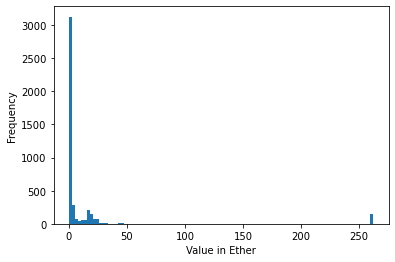

In [65]:
for rank, idx in enumerate(top_20_total_value_collections.index.values):
    collection_value = transfers[transfers['token_address'] == idx]['value']
    print(f"Rank {rank+1} collection by Total Value")
    print("SS: {}".format(collection_value.skew()))
    print(f"https://etherscan.io/address/{idx}/")
    collection_value.plot.hist(bins=100)
    plt.xlabel("Value in Ether")
    plt.show()

#### 6.4.3 Token Id
- Token Id is used to identify different NFTs within a collection (contract).
- Therefore, token_address + token_id is unique to each NFTs.

##### 6.4.3.1 Transaction Count per NFT
- Data looks much better than it did at the collection level.
- However, it is extremely noisy.
- It is very difficult to find any patter.

In [66]:
tx_count_per_nft = transfers.groupby(['token_address','token_id'])['block_timestamp'].count()
top_20_tx_count_nft = tx_count_per_nft.sort_values(ascending=False).head(20)

Rank 1 NFT by Tx Count
SS: -0.6969445791264731
https://opensea.io/assets/ethereum/0x81ae0be3a8044772d04f32398bac1e1b4b215aa8/164


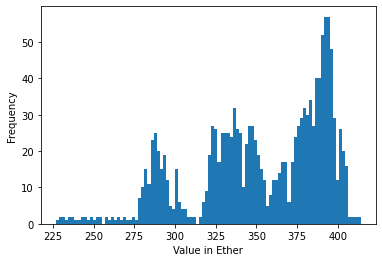

Rank 2 NFT by Tx Count
SS: -0.9756949869858692
https://opensea.io/assets/ethereum/0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7/689


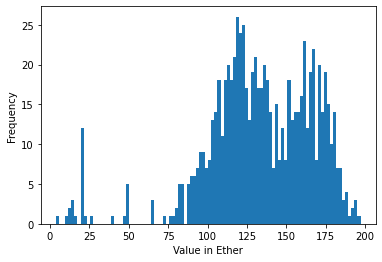

Rank 3 NFT by Tx Count
SS: -1.000672920799661
https://opensea.io/assets/ethereum/0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7/1938


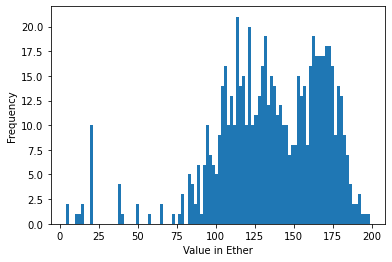

Rank 4 NFT by Tx Count
SS: -0.8014911921751754
https://opensea.io/assets/ethereum/0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7/19564


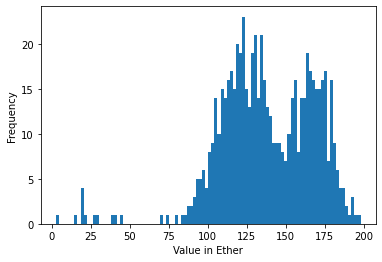

Rank 5 NFT by Tx Count
SS: -0.22258600015148214
https://opensea.io/assets/ethereum/0x1dfe7ca09e99d10835bf73044a23b73fc20623df/666688


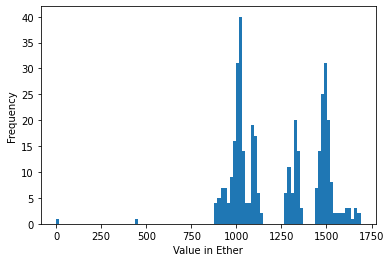

Rank 6 NFT by Tx Count
SS: -0.3569035616895273
https://opensea.io/assets/ethereum/0xccb9d89e0f77df3618eec9f6bf899be3b5561a89/13120


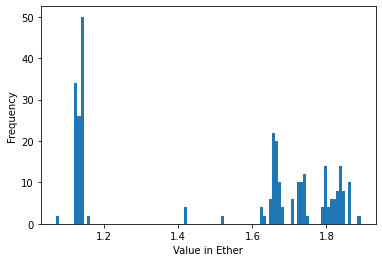

Rank 7 NFT by Tx Count
SS: -0.35732315142335946
https://opensea.io/assets/ethereum/0xccb9d89e0f77df3618eec9f6bf899be3b5561a89/16795


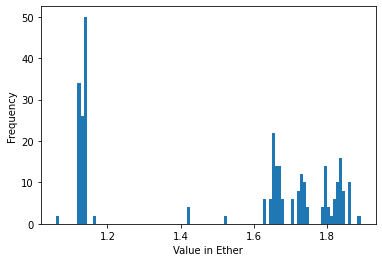

Rank 8 NFT by Tx Count
SS: -0.4566880552271327
https://opensea.io/assets/ethereum/0xccb9d89e0f77df3618eec9f6bf899be3b5561a89/37915


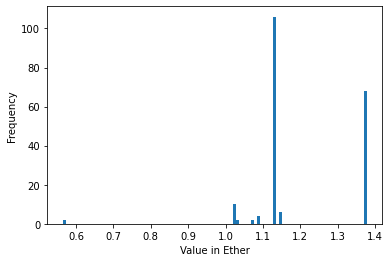

Rank 9 NFT by Tx Count
SS: -0.4566880552271327
https://opensea.io/assets/ethereum/0xccb9d89e0f77df3618eec9f6bf899be3b5561a89/37927


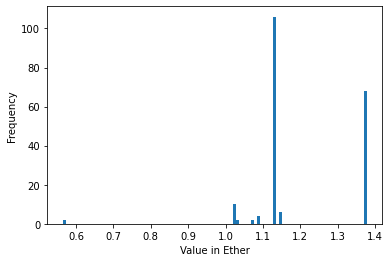

Rank 10 NFT by Tx Count
SS: -0.14546132761487707
https://opensea.io/assets/ethereum/0x79fcdef22feed20eddacbb2587640e45491b757f/99


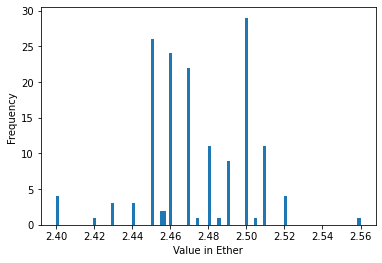

Rank 11 NFT by Tx Count
SS: 0
https://opensea.io/assets/ethereum/0x0b1d6565d88f9bf6473e21c2ab58d28a495d7bb5/1868


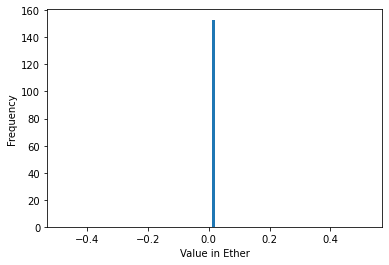

Rank 12 NFT by Tx Count
SS: 1.0980330744964173
https://opensea.io/assets/ethereum/0xed5af388653567af2f388e6224dc7c4b3241c544/6298


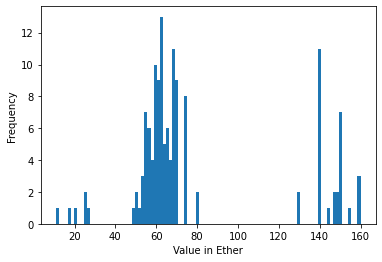

Rank 13 NFT by Tx Count
SS: -3.744244322201946
https://opensea.io/assets/ethereum/0xccb9d89e0f77df3618eec9f6bf899be3b5561a89/25203


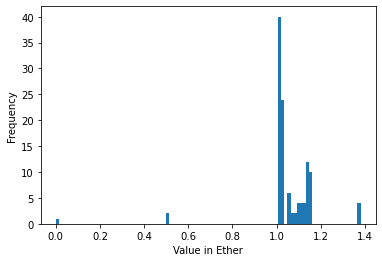

Rank 14 NFT by Tx Count
SS: -3.744244322201946
https://opensea.io/assets/ethereum/0xccb9d89e0f77df3618eec9f6bf899be3b5561a89/24079


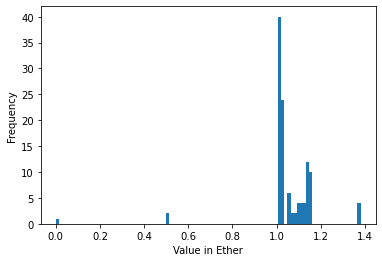

Rank 15 NFT by Tx Count
SS: 1.3889087598056968
https://opensea.io/assets/ethereum/0xb896c17c8e5e06ea393c4b2b79d5842fabcd3b94/6824


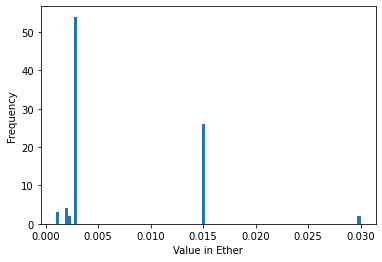

Rank 16 NFT by Tx Count
SS: 1.3889087598056968
https://opensea.io/assets/ethereum/0xb896c17c8e5e06ea393c4b2b79d5842fabcd3b94/6821


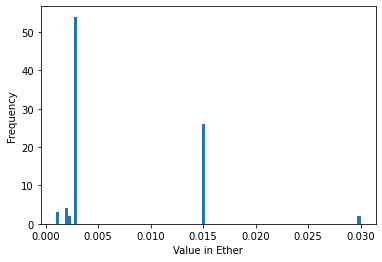

Rank 17 NFT by Tx Count
SS: 1.3889087598056968
https://opensea.io/assets/ethereum/0xb896c17c8e5e06ea393c4b2b79d5842fabcd3b94/6822


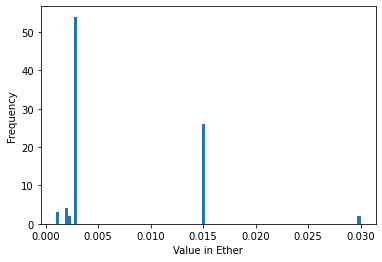

Rank 18 NFT by Tx Count
SS: 1.3889087598056968
https://opensea.io/assets/ethereum/0xb896c17c8e5e06ea393c4b2b79d5842fabcd3b94/6825


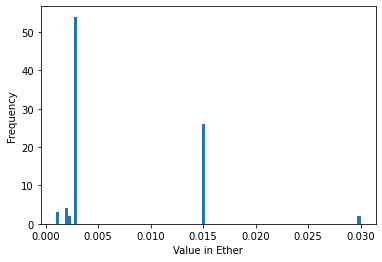

Rank 19 NFT by Tx Count
SS: 1.378423832905718
https://opensea.io/assets/ethereum/0xb896c17c8e5e06ea393c4b2b79d5842fabcd3b94/6823


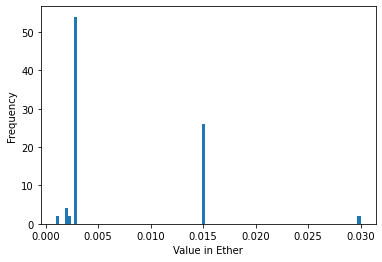

Rank 20 NFT by Tx Count
SS: 1.3476876601228527
https://opensea.io/assets/ethereum/0xb896c17c8e5e06ea393c4b2b79d5842fabcd3b94/7856


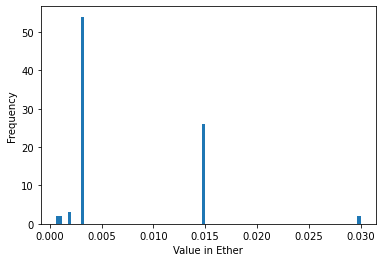

In [67]:
for rank, idx in enumerate(top_20_tx_count_nft.index.values):
    nft_value = transfers[(transfers['token_address'] == idx[0]) & (transfers['token_id'] == idx[1])]['value']
    print(f"Rank {rank+1} NFT by Tx Count")
    print("SS: {}".format(nft_value.skew()))
    print(f"https://opensea.io/assets/ethereum/{idx[0]}/{idx[1]}")
    nft_value.plot.hist(bins=100)
    plt.xlabel("Value in Ether")
    plt.show()

##### 6.4.3.2 Total Transaction Value per NFT
- Probably the best piece of data we have seen all day.
- With enough number of transactions, the price distribution within the NFT seems to be quiet well balanced.
- We want to remove high value transction with single transaction count (anomally).

In [68]:
total_value_per_nft = transfers.groupby(['token_address', 'token_id'])['value'].sum()
top_20_total_value = total_value_per_nft.sort_values(ascending=False).head(20)

Rank 1 NFT by Total Value
The number of transactions: 1400
SS: -0.6969445791264731
https://opensea.io/assets/ethereum/0x81ae0be3a8044772d04f32398bac1e1b4b215aa8/164


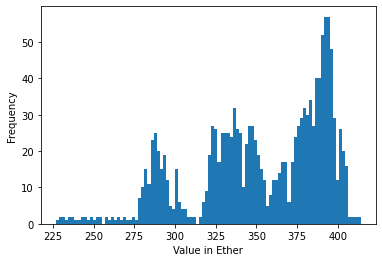

Rank 2 NFT by Total Value
The number of transactions: 376
SS: -0.22258600015148214
https://opensea.io/assets/ethereum/0x1dfe7ca09e99d10835bf73044a23b73fc20623df/666688


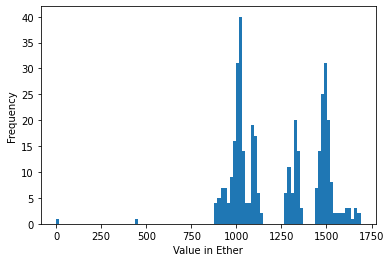

Rank 3 NFT by Total Value
The number of transactions: 797
SS: -0.9756949869858692
https://opensea.io/assets/ethereum/0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7/689


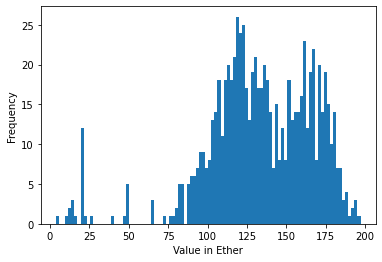

Rank 4 NFT by Total Value
The number of transactions: 655
SS: -0.8014911921751754
https://opensea.io/assets/ethereum/0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7/19564


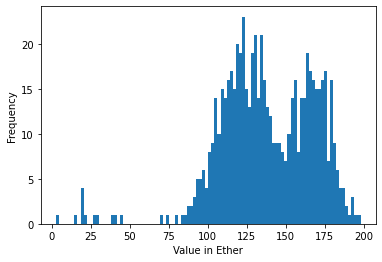

Rank 5 NFT by Total Value
The number of transactions: 665
SS: -1.000672920799661
https://opensea.io/assets/ethereum/0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7/1938


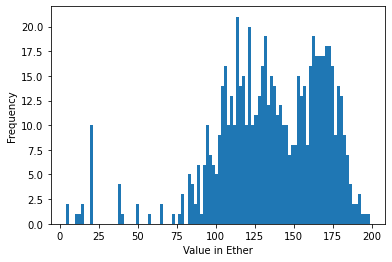

Rank 6 NFT by Total Value
The number of transactions: 34
SS: -0.36331436647843035
https://opensea.io/assets/ethereum/0x4e1f41613c9084fdb9e34e11fae9412427480e56/9559


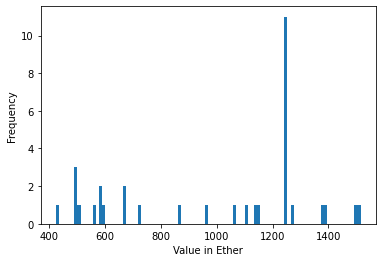

Rank 7 NFT by Total Value
The number of transactions: 35
SS: -0.04336159643805856
https://opensea.io/assets/ethereum/0x4e1f41613c9084fdb9e34e11fae9412427480e56/5283


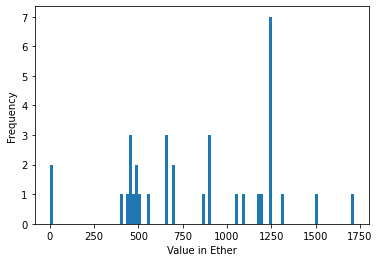

Rank 8 NFT by Total Value
The number of transactions: 1
SS: nan
https://opensea.io/assets/ethereum/0xc36442b4a4522e871399cd717abdd847ab11fe88/256128


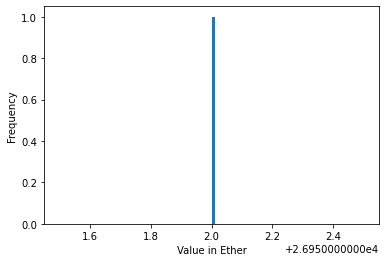

Rank 9 NFT by Total Value
The number of transactions: 1
SS: nan
https://opensea.io/assets/ethereum/0xc36442b4a4522e871399cd717abdd847ab11fe88/256596


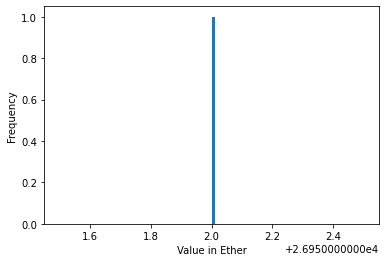

Rank 10 NFT by Total Value
The number of transactions: 1
SS: nan
https://opensea.io/assets/ethereum/0xc36442b4a4522e871399cd717abdd847ab11fe88/255078


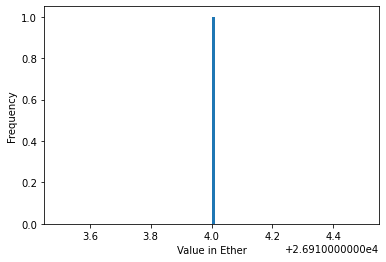

Rank 11 NFT by Total Value
The number of transactions: 1
SS: nan
https://opensea.io/assets/ethereum/0xc36442b4a4522e871399cd717abdd847ab11fe88/255042


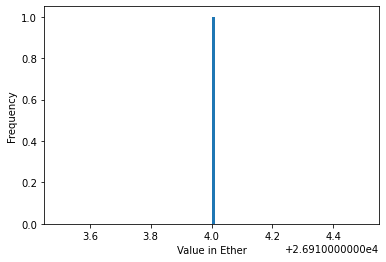

Rank 12 NFT by Total Value
The number of transactions: 1
SS: nan
https://opensea.io/assets/ethereum/0xc36442b4a4522e871399cd717abdd847ab11fe88/255203


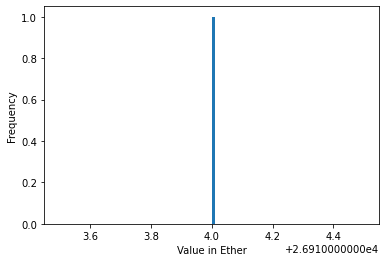

Rank 13 NFT by Total Value
The number of transactions: 1
SS: nan
https://opensea.io/assets/ethereum/0xc36442b4a4522e871399cd717abdd847ab11fe88/253618


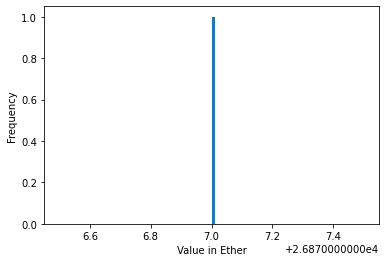

Rank 14 NFT by Total Value
The number of transactions: 1
SS: nan
https://opensea.io/assets/ethereum/0xc36442b4a4522e871399cd717abdd847ab11fe88/253569


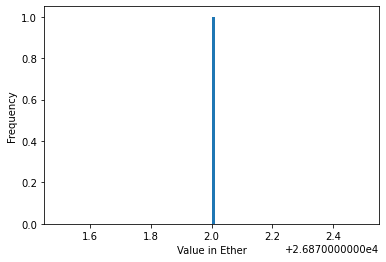

Rank 15 NFT by Total Value
The number of transactions: 23
SS: -1.3294741438221456
https://opensea.io/assets/ethereum/0x4e1f41613c9084fdb9e34e11fae9412427480e56/9728


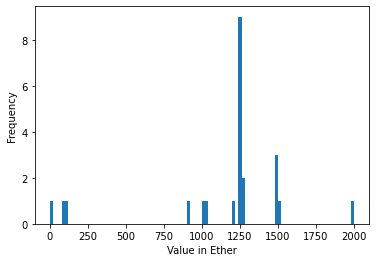

Rank 16 NFT by Total Value
The number of transactions: 1
SS: nan
https://opensea.io/assets/ethereum/0xc36442b4a4522e871399cd717abdd847ab11fe88/238341


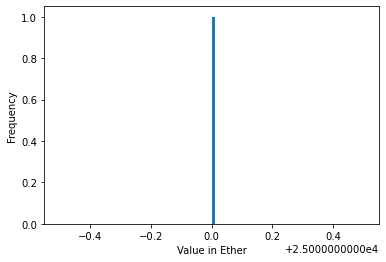

Rank 17 NFT by Total Value
The number of transactions: 1
SS: nan
https://opensea.io/assets/ethereum/0xc36442b4a4522e871399cd717abdd847ab11fe88/270490


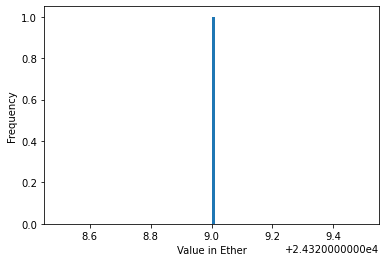

Rank 18 NFT by Total Value
The number of transactions: 1
SS: nan
https://opensea.io/assets/ethereum/0xc36442b4a4522e871399cd717abdd847ab11fe88/253381


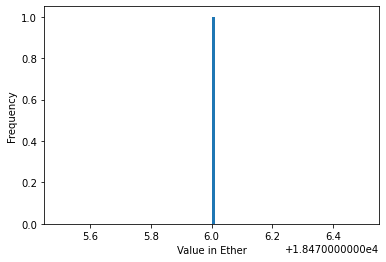

Rank 19 NFT by Total Value
The number of transactions: 1
SS: nan
https://opensea.io/assets/ethereum/0xc36442b4a4522e871399cd717abdd847ab11fe88/253333


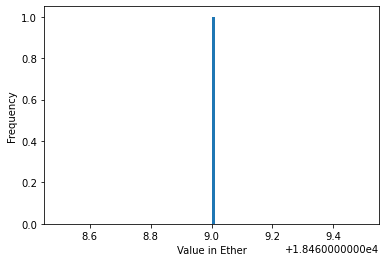

Rank 20 NFT by Total Value
The number of transactions: 1
SS: nan
https://opensea.io/assets/ethereum/0xc36442b4a4522e871399cd717abdd847ab11fe88/254912


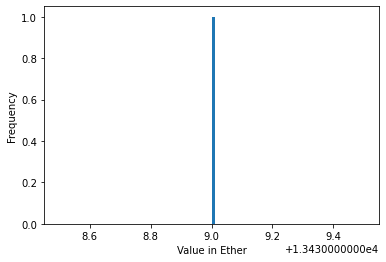

In [69]:
for rank, idx in enumerate(top_20_total_value.index.values):
    nft_value = transfers[(transfers['token_address'] == idx[0]) & (transfers['token_id'] == idx[1])]['value']
    print(f"Rank {rank+1} NFT by Total Value")
    print(f"The number of transactions: {nft_value.size}")
    print("SS: {}".format(nft_value.skew()))
    print(f"https://opensea.io/assets/ethereum/{idx[0]}/{idx[1]}")
    nft_value.plot.hist(bins=100)
    plt.xlabel("Value in Ether")
    plt.show()

### 6.5 Popular Collections
- Check the characteristics of poupular collections.
- They all have good amount of transaction counts.
- Distribution is pretty normal if we find a good section of data.
- We get good section by removing high outliers and transactions with value less than 10.
- Even for them a lot of trancation is around 0 ether.
- Try sum score and mean score and sum + mean score.
- For collection, the sum might be the best metric for now.

##### 6.5.1 Crytpo Punks

In [70]:
crypto_punks = transfers[transfers['token_address'] == "0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB".lower()]
crypto_punks

,amount,block_hash,block_number,block_timestamp,contract_type,from_address,log_index,operator,to_address,token_address,token_id,transaction_hash,transaction_index,transaction_type,value,verified
49253,1,0x9a987f613a1f691bbb363a7989ffd77f9c2dcf98a3ec...,14693983,2022-05-01T20:10:21.000Z,N/A,0xdb1c00a5cdc1849f999ff9e417a2556178cf73d7,78,N/A,0x1919db36ca2fa2e15f9000fd9cdc2edcf863e685,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,7402,0xcaa3db88ea33f38202022796565fe174f81321c533a4...,56,Single,62.690000,1
94547,1,0xf32a2a2fa5b4ee2ec709ca8d53d4b96889378956eb0b...,14693118,2022-05-01T16:51:59.000Z,N/A,0xed01f8a737813f0bda2d4340d191dbf8c2cbcf30,460,N/A,0xd9014705d2368dd097f2631b81965e85b3f5a0ba,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,2228,0x237fba9c8c8408303860289582b4b20f5da9661c6408...,287,Single,20.206624,1
94548,1,0xf32a2a2fa5b4ee2ec709ca8d53d4b96889378956eb0b...,14693118,2022-05-01T16:51:59.000Z,N/A,0xb7f7f6c52f2e2fdb1963eab30438024864c313f6,458,N/A,0xed01f8a737813f0bda2d4340d191dbf8c2cbcf30,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,2228,0x237fba9c8c8408303860289582b4b20f5da9661c6408...,287,Single,20.206624,1
177940,1,0x618c8f47a1df7e1f37d5ca1fb421d3fd68cdcf95ae2b...,14691815,2022-05-01T11:55:45.000Z,N/A,0xa9dc1bf6a46bc0d03c2b3d621d434dd6e998190d,296,N/A,0xc876b346d50c4199458ee0e3754883f62fe3a5b0,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,4894,0xbb91c6178c4a9a90ad8bd2a6398857414dd2909b8ede...,57,Single,110.000000,1
289090,1,0x232d1a601930fc95e06047d36fa45ebb1af74222d0bf...,14690367,2022-05-01T06:18:05.000Z,N/A,0x0e2c268410d5a9af2d293f365760bb4ff10932f4,30,N/A,0x1db5628f9443a603615beb064106bb159bedeebc,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,7181,0x9e40b4b2ca576278869ce391689d13afc996917ad078...,33,Single,63.990000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38350193,1,0xdd6856ef01f7579866c5009b7d22fb2050f75134e746...,15270822,2022-08-03T17:33:45.000Z,N/A,0x74806540d1429d177013c8b90a6679626a18cec8,145,N/A,0x1919db36ca2fa2e15f9000fd9cdc2edcf863e685,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,6118,0x5721ab8a7af731c0f48550fabd3744ed64f2089a77ab...,74,Single,80.000000,1
38352517,1,0x8686ab9941988afd479aa65399839f2325de5f8ecfd2...,15270810,2022-08-03T17:30:14.000Z,N/A,0x0232d1083e970f0c78f56202b9a666b526fa379f,249,N/A,0xaf5fc2a71fe35956bcd1ff7bf7ba73aa9e0c9a8b,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,6821,0xe3b9addfc7e5f9ba2f21d65125c8c155214118b685b2...,108,Single,78.950000,1
38354949,1,0xccb88c241519214503777e217499ab1d313a2d89f90b...,15270755,2022-08-03T17:18:58.000Z,N/A,0x457ec0c459f3ac559ceb48951675fbae4c744288,135,N/A,0x1919db36ca2fa2e15f9000fd9cdc2edcf863e685,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,4715,0xa262436758908209d537b101bf96e8fc26ceb05a31f5...,72,Single,81.950000,1
38357227,1,0xeaf369225787b0aed9cb13d9c4f14ae3681f5b46c291...,15270710,2022-08-03T17:10:18.000Z,N/A,0x0232d1083e970f0c78f56202b9a666b526fa379f,108,N/A,0x60e23da7a0b229902da892ddd6a839382eab04ca,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,2672,0x3aa3018a9f52696c4094bb381cabd8af42cda79d65a4...,54,Single,74.750000,1


In [71]:
crypto_punks.value.skew()

21.51867657137903

In [72]:
crypto_punks.value.describe()

count    1040.000000
mean       75.244275
std        87.357746
min         1.536868
25%        54.980000
50%        69.965000
75%        83.777500
max      2500.000000
Name: value, dtype: float64

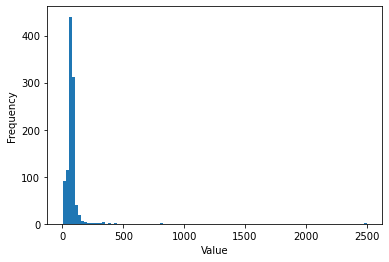

In [73]:
crypto_punks.value.plot.hist(bins=100)
plt.xlabel("Value")
plt.show()

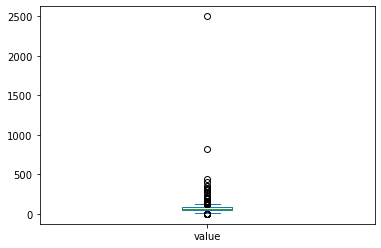

In [74]:
crypto_punks.value.plot.box()
plt.show()

In [75]:
cp_value_inliers = pd.Series(get_inliers(crypto_punks.value))

In [76]:
cp_value_inliers_3 = cp_value_inliers[cp_value_inliers > 10]
cp_value_inliers_3.skew()

-0.35701561673745025

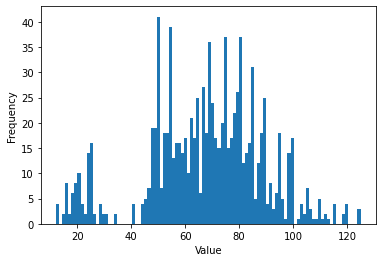

In [77]:
cp_value_inliers_3.plot.hist(bins=100)
plt.xlabel("Value")
plt.show()

In [78]:
cp_value_inliers_3.mean() 

67.77991595495236

In [79]:
cp_value_inliers_3.sum()

66763.21721562817

In [80]:
cp_score = cp_value_inliers_3.mean() + cp_value_inliers_3.sum()
cp_score

66830.99713158312

##### 6.5.2  BoredApes

In [81]:
bored_apes = transfers[transfers['token_address'] == "0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D".lower()]
bored_apes

,amount,block_hash,block_number,block_timestamp,contract_type,from_address,log_index,operator,to_address,token_address,token_id,transaction_hash,transaction_index,transaction_type,value,verified
12831,1,0x8e3312497e57e330d0f082245f43c67808eab3be1088...,14694780,2022-05-01T23:05:40.000Z,ERC721,0x90dfb72736481bbacc7938d2d3673590b92647ae,184,N/A,0xb7ef760f30d139097ba547bd6f0dfaecbf148452,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,1871,0xbd0cd3634e462ea61f3931af23458f8321756c6a622a...,100,Single,0.053914,1
19366,1,0x37134b1dcfac2c4dfff834c4c48fe9c8715f9726a3f4...,14694643,2022-05-01T22:38:01.000Z,ERC721,0x70b97a0da65c15dfb0ffa02aee6fa36e507c2762,430,N/A,0xb7ef760f30d139097ba547bd6f0dfaecbf148452,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,2329,0xa5c346dd50160a7a5d2ed2bedadddb23a7886d313578...,162,Single,54.143457,1
19367,1,0x37134b1dcfac2c4dfff834c4c48fe9c8715f9726a3f4...,14694643,2022-05-01T22:38:01.000Z,ERC721,0x5f6ac80cdb9e87f3cfa6a90e5140b9a16a361d5c,419,N/A,0x70b97a0da65c15dfb0ffa02aee6fa36e507c2762,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,2329,0xa5c346dd50160a7a5d2ed2bedadddb23a7886d313578...,162,Single,54.143457,1
19368,1,0x37134b1dcfac2c4dfff834c4c48fe9c8715f9726a3f4...,14694643,2022-05-01T22:38:01.000Z,ERC721,0xdbfd76af2157dc15ee4e57f3f942bb45ba84af24,416,N/A,0x5f6ac80cdb9e87f3cfa6a90e5140b9a16a361d5c,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,2329,0xa5c346dd50160a7a5d2ed2bedadddb23a7886d313578...,162,Single,54.143457,1
36548,1,0x7adb1d293da977c6defb018e6e5159f1c21eade388b5...,14694226,2022-05-01T21:04:13.000Z,ERC721,0x5d018611a65c87ac28f7f20007cbb1a96dc9e591,170,N/A,0xe0f5afbfa874cef79e67deb4f9bdbf96f36c9083,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,8829,0x0440ea28277e24c632fb421861acceb329053eeae1a9...,95,Single,126.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38491593,1,0xbff222025114c5a765cd3c9cd25d6df2f48f65c32ef1...,15268117,2022-08-03T07:14:50.000Z,ERC721,0x07c0872e541f05910cb2ff1f310f50f79555bd08,219,N/A,0x9e2344a4fb70e54ca31dc43ce8bce7fee75fb41d,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,314,0xc215ce844c893fd082737e6d39d0fc8aed7bfb253d35...,124,Single,79.000000,1
38548086,1,0x5649c441c4f3461eda408fa615a8fea61cb141cf5ddb...,15267097,2022-08-03T03:35:04.000Z,ERC721,0x4d7c645a178e4610b0bc45a738df908ab469943d,584,N/A,0x174e59a138d57556c8c883b36b7dafdbee391774,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,918,0xc9d9397ff66e9c884e4ab1efd7fe178ed1ab93e9f8eb...,407,Single,0.005000,1
38548087,1,0x5649c441c4f3461eda408fa615a8fea61cb141cf5ddb...,15267097,2022-08-03T03:35:04.000Z,ERC721,0x174e59a138d57556c8c883b36b7dafdbee391774,582,N/A,0x4d7c645a178e4610b0bc45a738df908ab469943d,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,7232,0xc9d9397ff66e9c884e4ab1efd7fe178ed1ab93e9f8eb...,407,Single,0.005000,1
38559850,1,0x6e8174deebc48d52ec27d33f4706930d1da3624cb1de...,15266893,2022-08-03T02:40:50.000Z,ERC721,0xdd94fe8f7e96d579e82f67d5b0ef6df493f72d80,674,N/A,0x174e59a138d57556c8c883b36b7dafdbee391774,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,7232,0x0479edbb4121df8fef7c23e2ad85b7a25b4a3e6d62b8...,363,Single,0.005000,1


In [82]:
bored_apes['value'].skew()

1.870019605572381

In [83]:
bored_apes.value.describe()

count    3.483000e+03
mean     7.753770e+01
std      6.253593e+01
min      1.100030e-09
25%      3.433492e+01
50%      8.200000e+01
75%      1.118439e+02
max      1.024000e+03
Name: value, dtype: float64

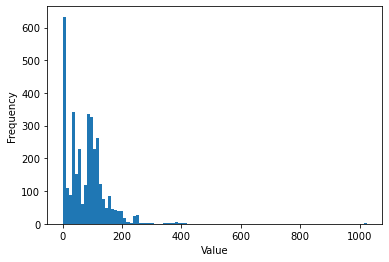

In [84]:
bored_apes['value'].plot.hist(bins=100)
plt.xlabel("Value")
plt.show()

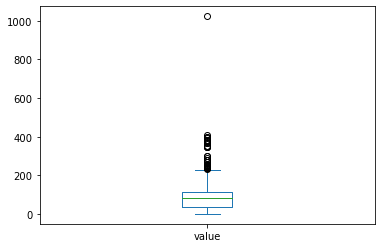

In [85]:
bored_apes.value.plot.box()
plt.show()

In [86]:
ba_inliers = pd.Series(get_inliers(bored_apes.value))

In [87]:
ba_inliers.skew()

0.313578964577042

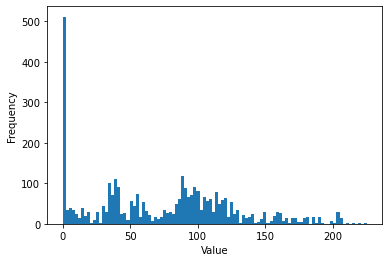

In [88]:
ba_inliers.plot.hist(bins=100)
plt.xlabel("Value")
plt.show()

In [89]:
ba_inliers_10 = ba_inliers[ba_inliers > 10]

In [90]:
ba_inliers_10.skew()

0.4314188731431569

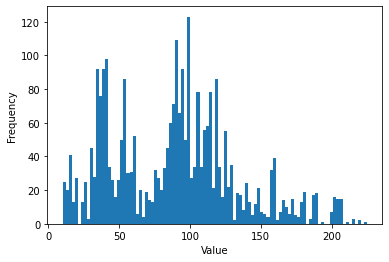

In [91]:
ba_inliers_10.plot.hist(bins=100)
plt.xlabel("Value")
plt.show()

In [92]:
ba_inliers_10.mean()

88.9347047907973

In [93]:
ba_inliers_10.sum()

248038.89166153315

In [94]:
ba_score = ba_inliers_10.mean() + ba_inliers_10.sum()
ba_score

248127.82636632395

##### 6.5.3 Mutant Ape Yacht Club

In [95]:
mutant_ape = transfers[transfers['token_address'] == "0x60E4d786628Fea6478F785A6d7e704777c86a7c6".lower()]
mutant_ape

,amount,block_hash,block_number,block_timestamp,contract_type,from_address,log_index,operator,to_address,token_address,token_id,transaction_hash,transaction_index,transaction_type,value,verified
249,1,0xab386e0cb9c974a856a08304cef7725b8022a01beb88...,14695004,2022-05-01T23:58:28.000Z,ERC721,0x068c0b630fddb7e5d1e3dc0d5a0fd3ee64e88e51,210,N/A,0x260c7afd82ec0dfd27a53b391d23d0f2b88a8677,0x60e4d786628fea6478f785a6d7e704777c86a7c6,295,0x87b290f02f8e8df26d084dcc4b2fd699ecba9d71adf8...,142,Single,25.98,1
2934,1,0x0c97185e9609b3c0d54e0e93b0d65826f630a067a945...,14694955,2022-05-01T23:45:40.000Z,ERC721,0x7f326925cb78f94e711d8dae10bb614f03291409,590,N/A,0x014f3a8bbcc20c17428a8ee9214f4923e30ba4ee,0x60e4d786628fea6478f785a6d7e704777c86a7c6,344,0x689d28d1fe7724160cd1544565fd50abe5a9ad13ace0...,201,Single,27.00,1
5676,1,0xf250f2d1c09067c02ebe7c1cbc5a9a3938ab6f99709b...,14694920,2022-05-01T23:37:05.000Z,ERC721,0x843f2c19bc6df9e32b482e2f9ad6c078001088b1,1,N/A,0x22cb8d9408623328fbc7189a657f118cd03eec9c,0x60e4d786628fea6478f785a6d7e704777c86a7c6,8222,0x622d05f4729ec68f6068fa29fd5cca876a45382838ce...,0,Single,26.70,1
5859,1,0x29d6efa3444c788687bdcb7287e3e363ec73d962dfa0...,14694916,2022-05-01T23:35:45.000Z,ERC721,0x98f591323a52635beea65ae57aad981dce27a59f,529,N/A,0x421789d625ce587ab9f545cc778502883f90442e,0x60e4d786628fea6478f785a6d7e704777c86a7c6,525,0xaed772dfcb32baa8e0efd0c84f4d2fb7850b8f748e28...,324,Single,29.99,1
7420,1,0xb8aaa57f94fdf465e3f639cdfaf12e0315bc1b262b79...,14694888,2022-05-01T23:31:17.000Z,ERC721,0xcaaaec015a35499cadc0229e7c73ec305643f444,36,N/A,0x8890cd645ce242a740415169a6959cd803e542f6,0x60e4d786628fea6478f785a6d7e704777c86a7c6,16815,0x6b3c75f9291d1bf4251f9f3fadf2666410dc076bded2...,27,Single,32.69,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38521787,1,0xd5a269dbbe30bea347e4f78cf06903f652017270b2a2...,15267564,2022-08-03T05:17:38.000Z,ERC721,0xc5825a27a03ff2fba429f49d7e337c4d4dd39400,141,N/A,0x9f0716bf7e4a4e19867599a54f1108e0c11fec98,0x60e4d786628fea6478f785a6d7e704777c86a7c6,5791,0xa24f58ceb00e328a05903df62e2b31637623ee8a9bab...,42,Single,36.00,1
38557576,1,0xd4350bd652bb5731028291d077a0360ca8a7acc71f1e...,15266949,2022-08-03T02:57:31.000Z,ERC721,0xc23d3085a6c132eb7bec00a471a2ba10658d7edc,413,N/A,0xf9eef0aa05d74f2b099b057e6f807f9904456eba,0x60e4d786628fea6478f785a6d7e704777c86a7c6,13180,0xe0ee33cdde8430804276a1a4a3620523de71ad090038...,254,Single,15.80,1
38571260,1,0x8cec885f59f545644151e4a3304a749d053eec6e60ac...,15266744,2022-08-03T02:02:56.000Z,ERC721,0x276417be271dbeb696cb97cda7c6982fd89e6bd4,143,N/A,0xa71a7a02efe2171940373472a3b1cd6966e2d95c,0x60e4d786628fea6478f785a6d7e704777c86a7c6,4649,0xd2dc01089b4c7057a83fb5c29822fa34c2c8c64eb66d...,120,Single,16.05,1
38586837,1,0x83066dddb72badd1ec2f3d139331a84775db7dfe425f...,15266433,2022-08-03T00:52:34.000Z,ERC721,0xd760ef23c9a203bd3718e91fc08b412ed49c5846,330,N/A,0x1618406d203aefa14526f77d79fdbeac9d42137b,0x60e4d786628fea6478f785a6d7e704777c86a7c6,9489,0xb6c646976e9a6f81749ccaa1a32aa9dfc951d59f1e77...,205,Single,17.30,1


In [96]:
mutant_ape.value.describe()

count    6035.000000
mean       21.058258
std        25.370720
min         0.001000
25%         9.877275
50%        18.880000
75%        24.700000
max       286.809000
Name: value, dtype: float64

In [97]:
ma_inliers = pd.Series(get_inliers(mutant_ape.value))

In [98]:
ma_inliers.skew()

0.057397779143904565

In [99]:
ma_inliers_10 = ma_inliers[ma_inliers > 10]

In [100]:
ma_inliers_10.skew()

1.159746290911114

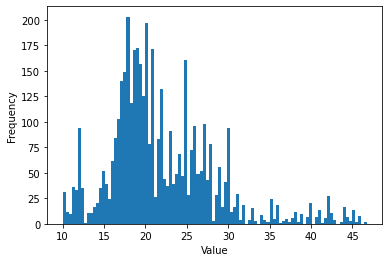

In [101]:
ma_inliers_10.plot.hist(bins=100)
plt.xlabel("Value")
plt.show()

In [102]:
ma_inliers_10.mean()

22.00858394612484

In [103]:
ma_inliers_10.sum()

94086.69636968354

In [104]:
ma_score = ma_inliers_10.mean() + ma_inliers_10.sum()

In [105]:
ma_score

94108.70495362967

##### 6.5.4 Moonbirds

In [106]:
moonbirds = transfers[transfers.token_address == "0x23581767a106ae21c074b2276D25e5C3e136a68b".lower()] 
moonbirds

,amount,block_hash,block_number,block_timestamp,contract_type,from_address,log_index,operator,to_address,token_address,token_id,transaction_hash,transaction_index,transaction_type,value,verified
330,1,0xc3932255fefad0ce92b904e2ec06f2704d9ce5ae1da2...,14695001,2022-05-01T23:58:09.000Z,ERC721,0xe43f60c0ef3fb1bd2b79759224e4307b5bf53607,38,N/A,0x4fee2d2e9ca2899f392ca656eccc3800e2c36bed,0x23581767a106ae21c074b2276d25e5c3e136a68b,805,0x4849d3364ee0c0c263f50bdb5048711cbfd9cfd28027...,31,Single,11.683319,1
2297,1,0x7b04d9864d7fc3b8a273c3ca2e4176a8509809b3bbf4...,14694966,2022-05-01T23:49:42.000Z,ERC721,0xcd6f234b7b0c6d42543cc56574cf256d92d9ec74,102,N/A,0xe87cc2ea916a7d471976b675d5f72302908e4590,0x23581767a106ae21c074b2276d25e5c3e136a68b,2239,0x1f32cc699373b05606854137dbcc4c0649ceefe77651...,81,Single,33.000000,1
6444,1,0x06abeebd8b65a01c4961476f96709e0ee47a5452f150...,14694909,2022-05-01T23:34:17.000Z,ERC721,0x483c069180324a165ee53c6fe327125d559e9478,54,N/A,0x5166d101c87b5914957515a78aa6015736b1b8f3,0x23581767a106ae21c074b2276d25e5c3e136a68b,2511,0x19cdf7226fbacec6ad5593978b5dfd20648d945949b7...,38,Single,31.000000,1
9365,1,0x26c78b6ba291b55ec3a2d619c99981b4eb5ad0832eef...,14694842,2022-05-01T23:21:57.000Z,ERC721,0xdbe8b36f62d26f09198b526129fcecaa51f9a455,204,N/A,0xe710592ac31387fcfc84666f8c108d7f38f29c2e,0x23581767a106ae21c074b2276d25e5c3e136a68b,4750,0x79a1cc7efd03a4a0bf3100939035cb5e8c4f4e5b7779...,121,Single,29.450000,1
9754,1,0x24e8c10cee065f4c6a1382a8ac4c9f34ad73f874bc70...,14694831,2022-05-01T23:19:42.000Z,ERC721,0x906ee0c8b6057953a7eaf935247a21f57fb4fafb,382,N/A,0xf49a2301d12d7dbbacff216a2bfb3c603dfc12e2,0x23581767a106ae21c074b2276d25e5c3e136a68b,691,0xfbe5e7292c9b7fa8bff5059721c65be13fe38d9fd3bb...,256,Single,29.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38458919,1,0x5739201d3e34a4cf146f0b0a01b7f880972feafe234c...,15268639,2022-08-03T09:12:38.000Z,ERC721,0x162bc440bd8474bc5e7da451a7dc0052f93b0c8b,55,N/A,0x7228a52ca531c87b371f91c71d6608a975b06e27,0x23581767a106ae21c074b2276d25e5c3e136a68b,1790,0x57585d9748d58c6e770f3009d3cbfad48553358dc6ab...,21,Single,37.950000,1
38458920,1,0x5739201d3e34a4cf146f0b0a01b7f880972feafe234c...,15268639,2022-08-03T09:12:38.000Z,ERC721,0x25c1541071258523322657289a4c2923c21185d2,53,N/A,0x7228a52ca531c87b371f91c71d6608a975b06e27,0x23581767a106ae21c074b2276d25e5c3e136a68b,3618,0x57585d9748d58c6e770f3009d3cbfad48553358dc6ab...,21,Single,37.950000,1
38473257,1,0xc8f5000791cb55a230a9101e7a21af3b7a5aa68446cf...,15268427,2022-08-03T08:18:59.000Z,ERC721,0x8c9926e50bb066b3feedc5f0ced73f7202fb035c,2,N/A,0x14395a809064c9beca62e94fb1a0bec538a6ec48,0x23581767a106ae21c074b2276d25e5c3e136a68b,3420,0x33b3749b5fcd73cd43800364cc9df74888d785e00673...,0,Single,16.000000,1
38515972,1,0xc95234f5d297fe5498586c936f83c209316c8b315985...,15267645,2022-08-03T05:35:33.000Z,ERC721,0x0ad56b522dee0dd29e9343f1c4615fcf009273e2,107,N/A,0x95ae8165ffedcef346b0b4375f9f12a581a19fd4,0x23581767a106ae21c074b2276d25e5c3e136a68b,6723,0xa890cc46f659d412cb646cae0400350307d19d68096b...,143,Single,18.930000,1


In [107]:
moonbirds.value.describe()

count    1951.000000
mean       41.800315
std       114.922322
min         0.005000
25%        18.500000
50%        22.300289
75%        27.760000
max       749.309000
Name: value, dtype: float64

In [108]:
ma_inliers = pd.Series(get_inliers(moonbirds.value))

In [109]:
ma_inliers.skew()

0.37445220162202975

In [110]:
ma_inliers_10 = ma_inliers[ma_inliers > 10]

In [111]:
ma_inliers_10.skew()

0.5988810328230555

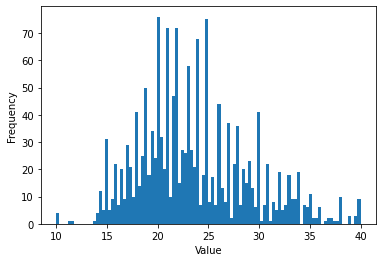

In [112]:
ma_inliers_10.plot.hist(bins=100)
plt.xlabel("Value")
plt.show()

In [113]:
ma_inliers_10.sum()

37420.44394223944

In [114]:
ma_inliers_10.mean()

23.638941214301667

In [115]:
ma_score = ma_inliers_10.sum() + ma_inliers_10.mean()

In [116]:
ma_score

37444.082883453746

### 6.6 Test Assumptions for Collection Ranking
- The best ranking that we can do based on current situation.
- The intuition is to get rid of ouliers as much as possible and try to rank with the portion of the data that we know is better.
- As we have seen from our anaysis, the sum of collection values gives decent ranking.

#### 1. Filter for tx count > 1000

In [117]:
tx_count = transfers.token_address.value_counts()

In [118]:
len(tx_count[tx_count > 1000].index)

1884

In [119]:
good = transfers[transfers.token_address.isin(tx_count[tx_count > 1000].index)]

#### 2. Filter out ERC1155 and ERC165

In [120]:
good = good[(good.contract_type != "ERC1155") & (good.contract_type != "ERC165")]

#### 3. Filter out value < 10 and outliers

In [121]:
good = good[good.value > 10]

In [122]:
good.value.describe()

count    82484.000000
mean        69.968087
std        402.445174
min         10.001600
25%         14.750000
50%         22.465900
75%         47.361771
max      26952.000000
Name: value, dtype: float64

In [123]:
good.value.skew()

39.93596044244699

In [124]:
inliers = get_inliers(good.value)

In [125]:
inliers.max()

96.266

In [126]:
good = good[good.value < 100]

In [127]:
good.value.skew()

1.6473684409491658

<AxesSubplot:ylabel='Frequency'>

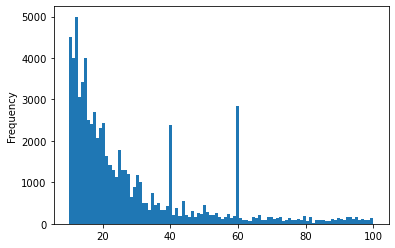

In [128]:
good.value.plot.hist(bins=100)

#### 4. Rank with AVG or SUM or AVG + SUM

##### AVG

In [129]:
collection_ranking_1 = good.groupby(['token_address'])['value'].sum().sort_values(ascending=False)
for rank, (address, score) in enumerate(collection_ranking_1.head(20).iteritems()):
    print(f"Rank {rank+1} with {score}")
    print(f"https://etherscan.io/address/{address}")

Rank 1 with 404865.5568540599
https://etherscan.io/address/0x34d85c9cdeb23fa97cb08333b511ac86e1c4e258
Rank 2 with 189167.81876447855
https://etherscan.io/address/0xc36442b4a4522e871399cd717abdd847ab11fe88
Rank 3 with 167640.8976
https://etherscan.io/address/0xad6917fc71101d377f5cbbc5b1fc0e941f08ae58
Rank 4 with 104326.68491710485
https://etherscan.io/address/0x60e4d786628fea6478f785a6d7e704777c86a7c6
Rank 5 with 103943.98568068712
https://etherscan.io/address/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d
Rank 6 with 85404.2
https://etherscan.io/address/0xc73d48167123430958049ca698137927b3c9441c
Rank 7 with 84753.42268582854
https://etherscan.io/address/0xed5af388653567af2f388e6224dc7c4b3241c544
Rank 8 with 61423.22721562817
https://etherscan.io/address/0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb
Rank 9 with 56757.64047708893
https://etherscan.io/address/0x8a90cab2b38dba80c64b7734e58ee1db38b8992e
Rank 10 with 51741.73882627188
https://etherscan.io/address/0x160c404b2b49cbc3240055ceaee026df1

##### SUM

In [130]:
collection_ranking_2 = good.groupby(['token_address'])['value'].mean().sort_values(ascending=False)
for rank, (address, score) in enumerate(collection_ranking_2.head(20).iteritems()):
    print(f"Rank {rank+1} with {score}")
    print(f"https://etherscan.io/address/{address}")

Rank 1 with 67.22361
https://etherscan.io/address/0x1fd468114d46b0315b702e8a332ff0a7d242d61d
Rank 2 with 65.62310599960274
https://etherscan.io/address/0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb
Rank 3 with 60.89278598751443
https://etherscan.io/address/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d
Rank 4 with 59.326666666666675
https://etherscan.io/address/0x445ede1ce0a4f6d05720cc691893c5bc3ea1bed7
Rank 5 with 56.76969102607518
https://etherscan.io/address/0xad6917fc71101d377f5cbbc5b1fc0e941f08ae58
Rank 6 with 54.861000000000004
https://etherscan.io/address/0x82c7a8f707110f5fbb16184a5933e9f78a34c6ab
Rank 7 with 50.88941176470588
https://etherscan.io/address/0x46ac8540d698167fcbb9e846511beb8cf8af9bd8
Rank 8 with 50.0
https://etherscan.io/address/0xafe7bb8c4cacbc8bd1a72318ada9e636aa6c9cca
Rank 9 with 45.7683
https://etherscan.io/address/0xd3605059c3ce9facf625fa72d727508b7b7f280f
Rank 10 with 44.90040643877358
https://etherscan.io/address/0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7
Rank 11 w

##### AVG + SUM

In [131]:
collection_ranking_3 = good.groupby(['token_address'])['value'].mean() + good.groupby(['token_address'])['value'].sum()
for rank, (address, score) in enumerate(collection_ranking_3.sort_values(ascending=False).head(20).iteritems()):
    print(f"Rank {rank+1} with {score}")
    print(f"https://etherscan.io/address/{address}")

Rank 1 with 404897.20923126687
https://etherscan.io/address/0x34d85c9cdeb23fa97cb08333b511ac86e1c4e258
Rank 2 with 189203.09810404672
https://etherscan.io/address/0xc36442b4a4522e871399cd717abdd847ab11fe88
Rank 3 with 167697.66729102607
https://etherscan.io/address/0xad6917fc71101d377f5cbbc5b1fc0e941f08ae58
Rank 4 with 104350.2562422104
https://etherscan.io/address/0x60e4d786628fea6478f785a6d7e704777c86a7c6
Rank 5 with 104004.87846667464
https://etherscan.io/address/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d
Rank 6 with 85441.80642888595
https://etherscan.io/address/0xc73d48167123430958049ca698137927b3c9441c
Rank 7 with 84772.7904698061
https://etherscan.io/address/0xed5af388653567af2f388e6224dc7c4b3241c544
Rank 8 with 61488.850321627775
https://etherscan.io/address/0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb
Rank 9 with 56778.763528997035
https://etherscan.io/address/0x8a90cab2b38dba80c64b7734e58ee1db38b8992e
Rank 10 with 51767.378934709086
https://etherscan.io/address/0x160c404b2b49cb

### 5. Rank with transformed value

In [132]:
good_log_value = good.value.apply(np.log)

<AxesSubplot:ylabel='Frequency'>

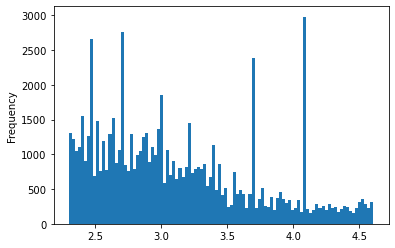

In [133]:
good_log_value.plot.hist(bins=100)

In [134]:
good_log_value.skew()

0.6451028992163941

In [135]:
good['log_value'] = good.apply(lambda row: np.log(row.value), axis=1)

In [136]:
collection_ranking_1 = good.groupby(['token_address'])['log_value'].sum().sort_values(ascending=False)
for rank, (address, score) in enumerate(collection_ranking_1.head(20).iteritems()):
    print(f"Rank {rank+1} with {score}")
    print(f"https://etherscan.io/address/{address}")

Rank 1 with 41921.3480339099
https://etherscan.io/address/0x34d85c9cdeb23fa97cb08333b511ac86e1c4e258
Rank 2 with 17989.203841614293
https://etherscan.io/address/0xc36442b4a4522e871399cd717abdd847ab11fe88
Rank 3 with 13672.94796114146
https://etherscan.io/address/0x60e4d786628fea6478f785a6d7e704777c86a7c6
Rank 4 with 12308.97956133717
https://etherscan.io/address/0xed5af388653567af2f388e6224dc7c4b3241c544
Rank 5 with 11844.158862848139
https://etherscan.io/address/0xad6917fc71101d377f5cbbc5b1fc0e941f08ae58
Rank 6 with 8175.70614900594
https://etherscan.io/address/0xc73d48167123430958049ca698137927b3c9441c
Rank 7 with 7880.991742542087
https://etherscan.io/address/0x8a90cab2b38dba80c64b7734e58ee1db38b8992e
Rank 8 with 6804.287645506172
https://etherscan.io/address/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d
Rank 9 with 6310.331630263063
https://etherscan.io/address/0x49cf6f5d44e70224e2e23fdcdd2c053f30ada28b
Rank 10 with 6182.977000348957
https://etherscan.io/address/0x160c404b2b49cbc32400

In [137]:
collection_ranking_2 = good.groupby(['token_address'])['log_value'].mean().sort_values(ascending=False)
for rank, (address, score) in enumerate(collection_ranking_2.head(20).iteritems()):
    print(f"Rank {rank+1} with {score}")
    print(f"https://etherscan.io/address/{address}")

Rank 1 with 4.1200547108248236
https://etherscan.io/address/0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb
Rank 2 with 4.101697148560088
https://etherscan.io/address/0x1fd468114d46b0315b702e8a332ff0a7d242d61d
Rank 3 with 4.031373595586832
https://etherscan.io/address/0x445ede1ce0a4f6d05720cc691893c5bc3ea1bed7
Rank 4 with 4.010890234625174
https://etherscan.io/address/0xad6917fc71101d377f5cbbc5b1fc0e941f08ae58
Rank 5 with 3.9861087554224794
https://etherscan.io/address/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d
Rank 6 with 3.912023005428146
https://etherscan.io/address/0xafe7bb8c4cacbc8bd1a72318ada9e636aa6c9cca
Rank 7 with 3.823591711742858
https://etherscan.io/address/0xd3605059c3ce9facf625fa72d727508b7b7f280f
Rank 8 with 3.7729298240640734
https://etherscan.io/address/0x0406243ca557c259712be750773177bc714e49f6
Rank 9 with 3.7674596380864767
https://etherscan.io/address/0xca0d2f057ee8faa06660ca0677b6df33c8e875ee
Rank 10 with 3.737060382152367
https://etherscan.io/address/0x82c7a8f707110f5f

In [138]:
collection_ranking_3 = good.groupby(['token_address'])['value'].mean() + good.groupby(['token_address'])['value'].sum()
for rank, (address, score) in enumerate(collection_ranking_3.head(20).sort_values(ascending=False).iteritems()):
    print(f"Rank {rank+1} with {score}")
    print(f"https://etherscan.io/address/{address}")

Rank 1 with 51767.378934709086
https://etherscan.io/address/0x160c404b2b49cbc3240055ceaee026df1e8497a0
Rank 2 with 9086.893095597568
https://etherscan.io/address/0x1792a96e5668ad7c167ab804a100ce42395ce54d
Rank 3 with 5237.907849592615
https://etherscan.io/address/0x05e7f2499ff153fea2f20bbde0b5584c911c0af1
Rank 4 with 2868.677367654318
https://etherscan.io/address/0x0a36f2178c0db2c85471c45334a1dd17d130fd42
Rank 5 with 1911.4858904109592
https://etherscan.io/address/0x0c2e57efddba8c768147d1fdf9176a0a6ebd5d83
Rank 6 with 1876.7406559346155
https://etherscan.io/address/0x123b30e25973fecd8354dd5f41cc45a3065ef88c
Rank 7 with 1794.6481186299043
https://etherscan.io/address/0x03ef30e1aee25abd320ad961b8cd31aa1a011c97
Rank 8 with 1531.0962852941177
https://etherscan.io/address/0x011c77fa577c500deedad364b8af9e8540b808c0
Rank 9 with 1228.4460651666645
https://etherscan.io/address/0x10cdcb5a80e888ec9e9154439e86b911f684da7b
Rank 10 with 1186.4121911764705
https://etherscan.io/address/0x02cf8ab518dd1

## 7. Conclusion

- EDA is the most important job to do before any machine learning or modeling.
    - Understand data before doing anything.
    - 知彼知己, 百戰不殆. 不知彼而知己, 一勝一負. 不知彼, 不知己. 每戰必殆.
- We need to get reliable data about price.
- Transaction value has the lead to the information that we are looking for not transaction counts.
- Collection level price distribution is heavily skewed to the right.
- NFT level price distribution is more balanced but might not be very useful for learning patterns because they can be very bimodal.